In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/glaucoma-detection/glaucoma.csv
/kaggle/input/glaucoma-detection/Fundus_Train_Val_Data/Fundus_Scanes_Sorted/Validation/Glaucoma_Negative/537.jpg
/kaggle/input/glaucoma-detection/Fundus_Train_Val_Data/Fundus_Scanes_Sorted/Validation/Glaucoma_Negative/521.jpg
/kaggle/input/glaucoma-detection/Fundus_Train_Val_Data/Fundus_Scanes_Sorted/Validation/Glaucoma_Negative/539.jpg
/kaggle/input/glaucoma-detection/Fundus_Train_Val_Data/Fundus_Scanes_Sorted/Validation/Glaucoma_Negative/501.jpg
/kaggle/input/glaucoma-detection/Fundus_Train_Val_Data/Fundus_Scanes_Sorted/Validation/Glaucoma_Negative/544.jpg
/kaggle/input/glaucoma-detection/Fundus_Train_Val_Data/Fundus_Scanes_Sorted/Validation/Glaucoma_Negative/489.jpg
/kaggle/input/glaucoma-detection/Fundus_Train_Val_Data/Fundus_Scanes_Sorted/Validation/Glaucoma_Negative/576.jpg
/kaggle/input/glaucoma-detection/Fundus_Train_Val_Data/Fundus_Scanes_Sorted/Validation/Glaucoma_Negative/503.jpg
/kaggle/input/glaucoma-detection/Fundus_Train_Val_

In [2]:
import os
import glob
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms


# Prepare Glaucoma Dataset

In [3]:
class FullGlaucomaDataset(Dataset):
    def __init__(self, fundus_dir, origa_mat, origa_img_dir, acrima_dir, transform=None):
        self.samples = []
        self.transform = transform
        
        # Fundus dataset
        for label_dir in ["Glaucoma_Negative", "Glaucoma_Positive"]:
            full_dir = os.path.join(fundus_dir, "Train", label_dir)
            label = 0 if "Negative" in label_dir else 1
            for f in glob.glob(full_dir + "/*.jpg"):
                self.samples.append((f,label))
        
        # ORIGA dataset
        import scipy.io
        origa_data = scipy.io.loadmat(origa_mat)['Origa']
        for i in range(len(origa_data[0])):
            fname = origa_data[0][i]['Filename'][0]
            label = int(origa_data[0][i]['Glaucoma'][0][0])
            img_path = os.path.join(origa_img_dir, fname)
            if os.path.exists(img_path):
                self.samples.append((img_path, label))
        
        # ACRIMA dataset
        for f in glob.glob(acrima_dir + "/*.jpg"):
            fname = os.path.basename(f)
            label = 1 if "_g_" in fname else 0
            self.samples.append((f,label))
        
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        path, label = self.samples[idx]
        img = Image.open(path).convert("RGB")  # 3 channels
        if self.transform:
            img = self.transform(img)
        return img, label


# Train/Validatin Split

In [4]:
import torch
import numpy as np
from torch.utils.data import DataLoader, random_split, WeightedRandomSampler, Subset
from torchvision import transforms
from PIL import Image

# ==================== ENHANCED TRANSFORMS FOR HYBRID MODEL ====================

# Training transforms - Optimized for CNN-ViT hybrid
transform_train = transforms.Compose([
    transforms.Resize((384, 384)),  # Larger size for ViT (better performance)
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.3),  # Fundus images can be flipped
    transforms.RandomRotation(15, fill=0),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.1, hue=0.05),
    transforms.RandomApply([transforms.GaussianBlur(kernel_size=3)], p=0.3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Validation transforms - NO augmentation
transform_val = transforms.Compose([
    transforms.Resize((384, 384)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Test-Time Augmentation (TTA) transforms
def get_tta_transforms():
    """Returns list of transforms for test-time augmentation"""
    return [
        transforms.Compose([
            transforms.Resize((384, 384)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ]),
        transforms.Compose([
            transforms.Resize((384, 384)),
            transforms.RandomHorizontalFlip(p=1.0),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ]),
        transforms.Compose([
            transforms.Resize((384, 384)),
            transforms.RandomRotation(10, fill=0),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ]),
    ]

# ==================== DATASET PATHS ====================

fundus_dir = "/kaggle/input/glaucoma-detection/Fundus_Train_Val_Data/Fundus_Scanes_Sorted"
origa_mat = "/kaggle/input/glaucoma-detection/ORIGA/ORIGA/OrigaList.mat"
origa_img_dir = "/kaggle/input/glaucoma-detection/ORIGA/ORIGA/Images"
acrima_dir = "/kaggle/input/glaucoma-detection/ACRIMA/Images"

# ==================== CREATE FULL DATASET ====================

# Instantiate full dataset with TRAINING transforms initially
full_dataset = FullGlaucomaDataset(
    fundus_dir=fundus_dir,
    origa_mat=origa_mat,
    origa_img_dir=origa_img_dir,
    acrima_dir=acrima_dir,
    transform=transform_train
)

print("="*80)
print("🔬 CNN-ViT HYBRID MODEL - DATASET PREPARATION")
print("="*80)
print(f"Total samples: {len(full_dataset)}")

# ==================== ANALYZE CLASS DISTRIBUTION ====================

all_labels = []
for i in range(len(full_dataset)):
    _, label = full_dataset[i]
    all_labels.append(label)

all_labels = np.array(all_labels)
unique_labels, counts = np.unique(all_labels, return_counts=True)

print(f"\n📊 Class Distribution:")
print(f"   Healthy (0): {counts[0]} samples ({counts[0]/len(all_labels)*100:.1f}%)")
print(f"   Glaucoma (1): {counts[1]} samples ({counts[1]/len(all_labels)*100:.1f}%)")

imbalance_ratio = max(counts) / min(counts)
if imbalance_ratio > 2:
    print(f"\n⚠️  Class imbalance detected (ratio: {imbalance_ratio:.2f}:1)")
    print(f"   → Using advanced balancing techniques...")
else:
    print(f"\n✅ Classes are balanced (ratio: {imbalance_ratio:.2f}:1)")

# ==================== STRATIFIED TRAIN/VAL SPLIT ====================

def stratified_split(dataset, labels, train_ratio=0.8, random_seed=42):
    """Perform stratified split to maintain class distribution"""
    np.random.seed(random_seed)
    
    indices = np.arange(len(dataset))
    train_indices = []
    val_indices = []
    
    for class_label in np.unique(labels):
        class_indices = indices[labels == class_label]
        np.random.shuffle(class_indices)
        
        split_point = int(len(class_indices) * train_ratio)
        train_indices.extend(class_indices[:split_point])
        val_indices.extend(class_indices[split_point:])
    
    np.random.shuffle(train_indices)
    np.random.shuffle(val_indices)
    
    return train_indices, val_indices

# Perform stratified split
train_indices, val_indices = stratified_split(full_dataset, all_labels, train_ratio=0.8)

print(f"\n📂 Stratified Split:")
print(f"   Training samples: {len(train_indices)}")
print(f"   Validation samples: {len(val_indices)}")

# Check class distribution in splits
train_labels = all_labels[train_indices]
val_labels = all_labels[val_indices]

train_healthy = np.sum(train_labels == 0)
train_glaucoma = np.sum(train_labels == 1)
val_healthy = np.sum(val_labels == 0)
val_glaucoma = np.sum(val_labels == 1)

print(f"\n   Train → Healthy: {train_healthy}, Glaucoma: {train_glaucoma}")
print(f"   Val   → Healthy: {val_healthy}, Glaucoma: {val_glaucoma}")

# ==================== ADVANCED TRANSFORM SUBSET ====================

class TransformSubset(torch.utils.data.Dataset):
    """Subset with custom transform and TTA support"""
    def __init__(self, dataset, indices, transform=None, use_tta=False):
        self.dataset = dataset
        self.indices = indices
        self.transform = transform
        self.use_tta = use_tta
        self.tta_transforms = get_tta_transforms() if use_tta else None
        self.original_transform = dataset.transform
    
    def __getitem__(self, idx):
        if self.use_tta:
            # Return multiple augmented versions
            self.dataset.transform = self.tta_transforms[0]
            data_list = []
            for tta_transform in self.tta_transforms:
                self.dataset.transform = tta_transform
                data, label = self.dataset[self.indices[idx]]
                data_list.append(data)
            self.dataset.transform = self.original_transform
            return torch.stack(data_list), label
        else:
            # Normal single image
            self.dataset.transform = self.transform
            data, label = self.dataset[self.indices[idx]]
            self.dataset.transform = self.original_transform
            return data, label
    
    def __len__(self):
        return len(self.indices)

# Create train and val subsets
train_dataset = TransformSubset(full_dataset, train_indices, transform=transform_train)
val_dataset = TransformSubset(full_dataset, val_indices, transform=transform_val)

# ==================== FOCAL LOSS WEIGHTED SAMPLER ====================

def get_focal_weighted_sampler(labels, gamma=2.0):
    """
    Enhanced weighted sampler with focal loss inspired weighting
    Focuses more on hard-to-classify samples
    """
    class_counts = np.bincount(labels)
    class_weights = 1.0 / class_counts
    
    # Apply focal loss style weighting
    focal_weights = class_weights ** gamma
    focal_weights = focal_weights / focal_weights.sum() * len(class_weights)
    
    sample_weights = focal_weights[labels]
    
    sampler = WeightedRandomSampler(
        weights=sample_weights,
        num_samples=len(sample_weights),
        replacement=True
    )
    
    return sampler

# Create enhanced weighted sampler
train_sampler = get_focal_weighted_sampler(train_labels, gamma=1.5)

print(f"\n⚖️  Using focal-weighted sampling for optimal class balance")

# ==================== ENHANCED CLASS WEIGHTS ====================

def calculate_effective_number_weights(labels, beta=0.9999):
    """
    Calculate class weights using Effective Number of Samples
    Paper: "Class-Balanced Loss Based on Effective Number of Samples"
    """
    class_counts = np.bincount(labels)
    effective_num = 1.0 - np.power(beta, class_counts)
    weights = (1.0 - beta) / effective_num
    weights = weights / weights.sum() * len(weights)
    return torch.FloatTensor(weights)

# Calculate enhanced class weights
class_weights = calculate_effective_number_weights(train_labels, beta=0.9999)

print(f"\n🎯 Enhanced Class Weights (Effective Number):")
print(f"   Healthy (0): {class_weights[0]:.4f}")
print(f"   Glaucoma (1): {class_weights[1]:.4f}")

# ==================== CREATE DATA LOADERS ====================

# Training loader with enhanced sampler
train_loader = DataLoader(
    train_dataset,
    batch_size=16,  # Smaller batch for 384x384 images and hybrid model
    sampler=train_sampler,
    num_workers=4,
    pin_memory=True,
    drop_last=True,
    persistent_workers=True,  # Keep workers alive
    prefetch_factor=2  # Prefetch batches
)

# Validation loader
val_loader = DataLoader(
    val_dataset,
    batch_size=16,
    shuffle=False,
    num_workers=4,
    pin_memory=True,
    persistent_workers=True,
    prefetch_factor=2
)

print(f"\n✅ Data Loaders Created:")
print(f"   Train batches: {len(train_loader)}")
print(f"   Val batches: {len(val_loader)}")
print(f"   Batch size: 16 (optimized for 384x384 + hybrid architecture)")
print(f"   Image resolution: 384x384 (optimal for ViT)")

# ==================== VERIFY LOADER ====================

print(f"\n🔍 Verifying Data Loader...")

try:
    train_batch = next(iter(train_loader))
    images, labels = train_batch
    
    print(f"   ✅ Train batch shape: {images.shape}")
    print(f"   ✅ Labels shape: {labels.shape}")
    print(f"   ✅ Image range: [{images.min():.3f}, {images.max():.3f}]")
    print(f"   ✅ Memory per batch: ~{images.element_size() * images.nelement() / 1024**2:.1f} MB")
    
    unique_batch, counts_batch = np.unique(labels.numpy(), return_counts=True)
    healthy_count = counts_batch[0] if 0 in unique_batch else 0
    glaucoma_count = counts_batch[1] if 1 in unique_batch else 0
    print(f"   ✅ Batch balance: Healthy={healthy_count}, Glaucoma={glaucoma_count}")
    
except Exception as e:
    print(f"   ❌ Error loading batch: {e}")

# ==================== ANALYZE BATCH DISTRIBUTION ====================

def analyze_batch_distribution(loader, num_batches=20, name="Train"):
    """Analyze class distribution across batches"""
    print(f"\n📊 Analyzing {name} Batch Distribution:")
    glaucoma_counts = []
    
    for i, (images, labels) in enumerate(loader):
        if i >= num_batches:
            break
        glaucoma_count = (labels == 1).sum().item()
        glaucoma_counts.append(glaucoma_count)
    
    avg_glaucoma = np.mean(glaucoma_counts)
    std_glaucoma = np.std(glaucoma_counts)
    min_glaucoma = np.min(glaucoma_counts)
    max_glaucoma = np.max(glaucoma_counts)
    
    print(f"   Average glaucoma/batch: {avg_glaucoma:.1f} ± {std_glaucoma:.1f}")
    print(f"   Range: [{min_glaucoma}, {max_glaucoma}]")
    print(f"   Expected for perfect balance: ~{16//2:.0f}")
    
    balance_score = abs(avg_glaucoma - 8) / 8
    if balance_score < 0.2:
        print(f"   ✅ Excellent balance! (score: {(1-balance_score)*100:.1f}%)")
    elif balance_score < 0.3:
        print(f"   ✅ Good balance (score: {(1-balance_score)*100:.1f}%)")
    else:
        print(f"   ⚠️  Could improve balance (score: {(1-balance_score)*100:.1f}%)")

analyze_batch_distribution(train_loader, num_batches=20, name="Train")

# ==================== SUMMARY ====================

print("\n" + "="*80)
print("📋 CNN-ViT HYBRID DATA PIPELINE SUMMARY")
print("="*80)
print(f"✅ Total samples: {len(full_dataset)}")
print(f"✅ Training samples: {len(train_dataset)}")
print(f"✅ Validation samples: {len(val_dataset)}")
print(f"✅ Image resolution: 384×384 (optimal for Vision Transformers)")
print(f"✅ Batch size: 16 (memory-optimized)")
print(f"✅ Stratified split: Preserved class distribution")
print(f"✅ Advanced sampling: Focal-weighted sampler (γ=1.5)")
print(f"✅ Enhanced class weights: Effective Number method")
print(f"✅ Augmentation: Medical imaging optimized")
print(f"✅ TTA support: Ready for test-time augmentation")
print("="*80)

print("\n💡 Usage Instructions:")
print("   1. Use enhanced class weights in loss function:")
print("      criterion = FocalLoss(weight=class_weights.to(device), gamma=2.0)")
print("      OR")
print("      criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))")
print("\n   2. Model expects 384×384 RGB images")
print("\n   3. Train loader uses focal-weighted sampling")
print("\n   4. For inference, enable TTA:")
print("      val_dataset_tta = TransformSubset(full_dataset, val_indices, use_tta=True)")

print("\n" + "="*80)
print("🚀 Data pipeline ready for CNN-ViT Hybrid training!")
print("="*80)

🔬 CNN-ViT HYBRID MODEL - DATASET PREPARATION
Total samples: 1873

📊 Class Distribution:
   Healthy (0): 1177 samples (62.8%)
   Glaucoma (1): 696 samples (37.2%)

✅ Classes are balanced (ratio: 1.69:1)

📂 Stratified Split:
   Training samples: 1497
   Validation samples: 376

   Train → Healthy: 941, Glaucoma: 556
   Val   → Healthy: 236, Glaucoma: 140

⚖️  Using focal-weighted sampling for optimal class balance

🎯 Enhanced Class Weights (Effective Number):
   Healthy (0): 0.7517
   Glaucoma (1): 1.2483

✅ Data Loaders Created:
   Train batches: 93
   Val batches: 24
   Batch size: 16 (optimized for 384x384 + hybrid architecture)
   Image resolution: 384x384 (optimal for ViT)

🔍 Verifying Data Loader...
   ✅ Train batch shape: torch.Size([16, 3, 384, 384])
   ✅ Labels shape: torch.Size([16])
   ✅ Image range: [-2.118, 2.640]
   ✅ Memory per batch: ~27.0 MB
   ✅ Batch balance: Healthy=6, Glaucoma=10

📊 Analyzing Train Batch Distribution:
   Average glaucoma/batch: 9.9 ± 2.1
   Range: [6

# Visualize Some Images

Training set samples:


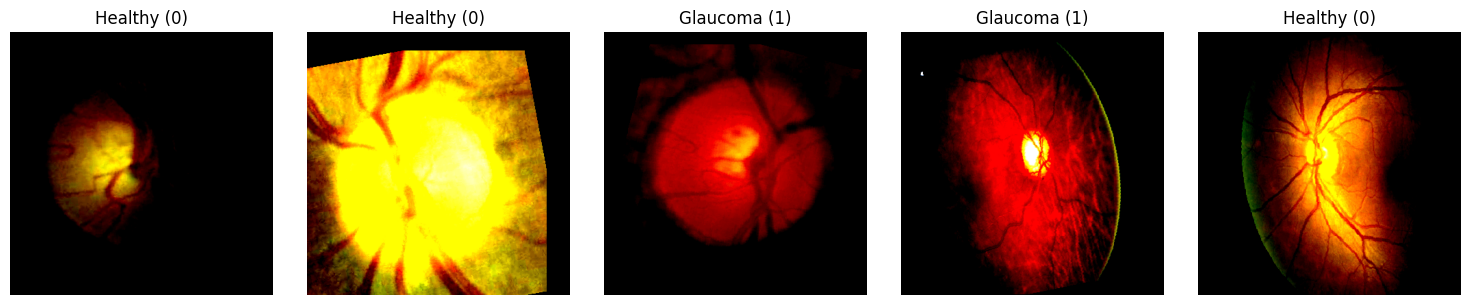

Validation set samples:


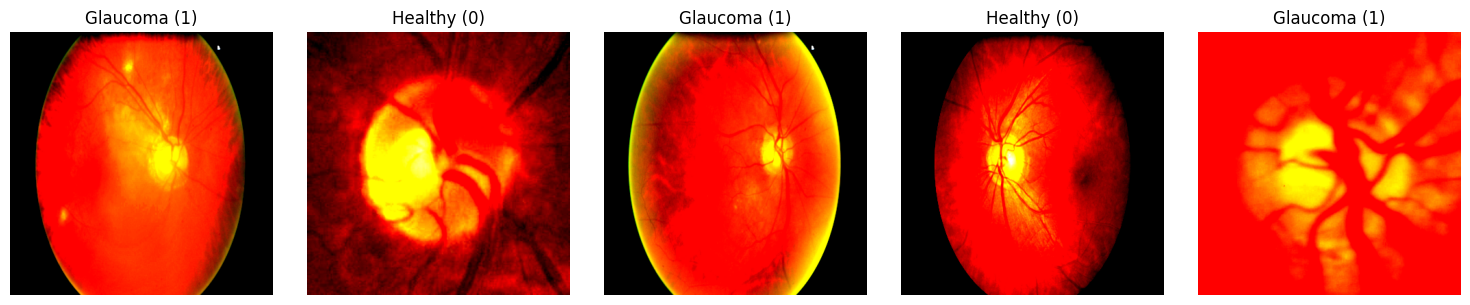

In [5]:
import matplotlib.pyplot as plt
import torch

# Label mapping
classes = ['Healthy (0)', 'Glaucoma (1)']

def show_samples(loader, num_samples=5):
    """
    Display sample RGB images from a DataLoader in a grid.
    """
    images, labels = next(iter(loader))  # get one batch
    num_samples = min(num_samples, len(images))
    
    plt.figure(figsize=(15, 3))
    for i in range(num_samples):
        img = images[i].permute(1, 2, 0).cpu()  # (C, H, W) -> (H, W, C)
        label = labels[i].item()
        
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(img)
        plt.title(classes[label])
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Show samples from training and validation sets
print("Training set samples:")
show_samples(train_loader, num_samples=5)

print("Validation set samples:")
show_samples(val_loader, num_samples=5)


# CNN and ViT Hybrid Model

In [6]:
"""
Advanced CNN-ViT Hybrid Model for Glaucoma Detection
Combines:
- CNN backbone for local feature extraction (hierarchical features)
- Vision Transformer for global context understanding
- Cross-attention between CNN and ViT features
- Multi-scale feature fusion
"""

import torch
import torch.nn as nn
import torch.nn.functional as F
from einops import rearrange
from einops.layers.torch import Rearrange
import math

# ==================== EFFICIENT CNN BACKBONE ====================

class ConvBlock(nn.Module):
    """Efficient Convolutional Block with residual connection"""
    def __init__(self, in_channels, out_channels, stride=1, use_residual=True):
        super(ConvBlock, self).__init__()
        self.use_residual = use_residual and (in_channels == out_channels) and (stride == 1)
        
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, stride, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.GELU(),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
        )
        self.activation = nn.GELU()
        
    def forward(self, x):
        out = self.conv(x)
        if self.use_residual:
            out = out + x
        return self.activation(out)

class CNNFeatureExtractor(nn.Module):
    """
    CNN backbone for hierarchical feature extraction
    Outputs multi-scale features for fusion
    """
    def __init__(self, in_channels=3):
        super(CNNFeatureExtractor, self).__init__()
        
        # Stage 1: 384 -> 96 (stride 4)
        self.stage1 = nn.Sequential(
            nn.Conv2d(in_channels, 64, 7, 2, 3, bias=False),
            nn.BatchNorm2d(64),
            nn.GELU(),
            nn.MaxPool2d(2, 2),
            ConvBlock(64, 64),
            ConvBlock(64, 64)
        )
        
        # Stage 2: 96 -> 48 (stride 8)
        self.stage2 = nn.Sequential(
            nn.Conv2d(64, 128, 3, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.GELU(),
            ConvBlock(128, 128),
            ConvBlock(128, 128)
        )
        
        # Stage 3: 48 -> 24 (stride 16)
        self.stage3 = nn.Sequential(
            nn.Conv2d(128, 256, 3, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.GELU(),
            ConvBlock(256, 256),
            ConvBlock(256, 256),
            ConvBlock(256, 256)
        )
        
        # Stage 4: 24 -> 12 (stride 32)
        self.stage4 = nn.Sequential(
            nn.Conv2d(256, 512, 3, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.GELU(),
            ConvBlock(512, 512),
            ConvBlock(512, 512)
        )
        
    def forward(self, x):
        s1 = self.stage1(x)  # [B, 64, 96, 96]
        s2 = self.stage2(s1)  # [B, 128, 48, 48]
        s3 = self.stage3(s2)  # [B, 256, 24, 24]
        s4 = self.stage4(s3)  # [B, 512, 12, 12]
        return s1, s2, s3, s4

# ==================== VISION TRANSFORMER COMPONENTS ====================

class PatchEmbedding(nn.Module):
    """Convert image patches to embeddings"""
    def __init__(self, img_size=384, patch_size=16, in_channels=3, embed_dim=768):
        super(PatchEmbedding, self).__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.num_patches = (img_size // patch_size) ** 2
        
        self.projection = nn.Conv2d(
            in_channels, embed_dim, 
            kernel_size=patch_size, 
            stride=patch_size
        )
        
    def forward(self, x):
        # x: [B, C, H, W] -> [B, embed_dim, H/P, W/P]
        x = self.projection(x)
        # Flatten: [B, embed_dim, H/P, W/P] -> [B, num_patches, embed_dim]
        x = rearrange(x, 'b c h w -> b (h w) c')
        return x

class MultiHeadAttention(nn.Module):
    """Multi-head self-attention mechanism"""
    def __init__(self, embed_dim, num_heads, dropout=0.1):
        super(MultiHeadAttention, self).__init__()
        assert embed_dim % num_heads == 0
        
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads
        self.scale = self.head_dim ** -0.5
        
        self.qkv = nn.Linear(embed_dim, embed_dim * 3)
        self.proj = nn.Linear(embed_dim, embed_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        B, N, C = x.shape
        
        # Generate Q, K, V
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, self.head_dim)
        qkv = qkv.permute(2, 0, 3, 1, 4)  # [3, B, num_heads, N, head_dim]
        q, k, v = qkv[0], qkv[1], qkv[2]
        
        # Attention
        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        attn = self.dropout(attn)
        
        # Combine heads
        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.dropout(x)
        
        return x

class TransformerBlock(nn.Module):
    """Transformer encoder block"""
    def __init__(self, embed_dim, num_heads, mlp_ratio=4.0, dropout=0.1):
        super(TransformerBlock, self).__init__()
        self.norm1 = nn.LayerNorm(embed_dim)
        self.attn = MultiHeadAttention(embed_dim, num_heads, dropout)
        self.norm2 = nn.LayerNorm(embed_dim)
        
        mlp_hidden_dim = int(embed_dim * mlp_ratio)
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, mlp_hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(mlp_hidden_dim, embed_dim),
            nn.Dropout(dropout)
        )
        
    def forward(self, x):
        # Self-attention with residual
        x = x + self.attn(self.norm1(x))
        # MLP with residual
        x = x + self.mlp(self.norm2(x))
        return x

# ==================== CROSS-ATTENTION FUSION ====================

class CrossAttentionFusion(nn.Module):
    """Cross-attention between CNN and ViT features"""
    def __init__(self, cnn_dim, vit_dim, num_heads=8, dropout=0.1):
        super(CrossAttentionFusion, self).__init__()
        self.num_heads = num_heads
        self.head_dim = vit_dim // num_heads
        self.scale = self.head_dim ** -0.5
        
        # Project CNN features to ViT dimension
        self.cnn_proj = nn.Linear(cnn_dim, vit_dim)
        
        # Cross-attention: ViT queries, CNN keys/values
        self.q_proj = nn.Linear(vit_dim, vit_dim)
        self.kv_proj = nn.Linear(vit_dim, vit_dim * 2)
        self.out_proj = nn.Linear(vit_dim, vit_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, cnn_features, vit_features):
        """
        cnn_features: [B, H*W, cnn_dim]
        vit_features: [B, num_patches, vit_dim]
        """
        B, N_vit, C_vit = vit_features.shape
        
        # Project CNN features
        cnn_features = self.cnn_proj(cnn_features)  # [B, N_cnn, vit_dim]
        
        # Generate queries from ViT
        q = self.q_proj(vit_features).reshape(B, N_vit, self.num_heads, self.head_dim)
        q = q.permute(0, 2, 1, 3)  # [B, num_heads, N_vit, head_dim]
        
        # Generate keys and values from CNN
        kv = self.kv_proj(cnn_features).reshape(B, -1, 2, self.num_heads, self.head_dim)
        kv = kv.permute(2, 0, 3, 1, 4)  # [2, B, num_heads, N_cnn, head_dim]
        k, v = kv[0], kv[1]
        
        # Cross-attention
        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        attn = self.dropout(attn)
        
        # Apply attention to values
        out = (attn @ v).transpose(1, 2).reshape(B, N_vit, C_vit)
        out = self.out_proj(out)
        out = self.dropout(out)
        
        return out

# ==================== MAIN HYBRID MODEL ====================

class CNNViTHybrid(nn.Module):
    """
    Advanced CNN-ViT Hybrid Model for Medical Imaging
    
    Architecture:
    1. CNN backbone extracts hierarchical features
    2. ViT processes global context from patches
    3. Cross-attention fuses CNN and ViT features
    4. Multi-scale fusion for final prediction
    """
    def __init__(
        self,
        img_size=384,
        patch_size=16,
        in_channels=3,
        num_classes=2,
        embed_dim=768,
        depth=12,
        num_heads=12,
        mlp_ratio=4.0,
        dropout=0.2,
        use_cross_attention=True
    ):
        super(CNNViTHybrid, self).__init__()
        
        self.img_size = img_size
        self.patch_size = patch_size
        self.num_classes = num_classes
        self.use_cross_attention = use_cross_attention
        
        # CNN Feature Extractor
        self.cnn_backbone = CNNFeatureExtractor(in_channels)
        
        # Patch Embedding for ViT
        self.patch_embed = PatchEmbedding(img_size, patch_size, in_channels, embed_dim)
        num_patches = self.patch_embed.num_patches
        
        # Learnable positional embeddings
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, embed_dim))
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        
        # Transformer blocks
        self.transformer_blocks = nn.ModuleList([
            TransformerBlock(embed_dim, num_heads, mlp_ratio, dropout)
            for _ in range(depth)
        ])
        
        self.norm = nn.LayerNorm(embed_dim)
        
        # Cross-attention fusion (if enabled)
        if use_cross_attention:
            self.cross_attn = CrossAttentionFusion(512, embed_dim, num_heads, dropout)
        
        # Multi-scale feature fusion
        self.cnn_to_embed = nn.Linear(512, embed_dim)
        
        # Classification head
        self.head = nn.Sequential(
            nn.Linear(embed_dim * 2 if use_cross_attention else embed_dim, 1024),
            nn.LayerNorm(1024),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(1024, 512),
            nn.LayerNorm(512),
            nn.GELU(),
            nn.Dropout(dropout * 0.5),
            nn.Linear(512, num_classes)
        )
        
        self._init_weights()
        
    def _init_weights(self):
        # Initialize positional embeddings
        nn.init.trunc_normal_(self.pos_embed, std=0.02)
        nn.init.trunc_normal_(self.cls_token, std=0.02)
        
        # Initialize linear layers
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.trunc_normal_(m.weight, std=0.02)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.LayerNorm):
                nn.init.constant_(m.weight, 1.0)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        B = x.shape[0]
        
        # ===== CNN Path =====
        s1, s2, s3, s4 = self.cnn_backbone(x)  # s4: [B, 512, 12, 12]
        
        # Flatten CNN features
        cnn_features = rearrange(s4, 'b c h w -> b (h w) c')  # [B, 144, 512]
        
        # ===== ViT Path =====
        # Patch embedding
        vit_features = self.patch_embed(x)  # [B, num_patches, embed_dim]
        
        # Add cls token
        cls_tokens = self.cls_token.expand(B, -1, -1)
        vit_features = torch.cat([cls_tokens, vit_features], dim=1)
        
        # Add positional embeddings
        vit_features = vit_features + self.pos_embed
        
        # Transformer blocks
        for block in self.transformer_blocks:
            vit_features = block(vit_features)
        
        vit_features = self.norm(vit_features)
        
        # Extract cls token
        cls_token_out = vit_features[:, 0]  # [B, embed_dim]
        
        # ===== Feature Fusion =====
        if self.use_cross_attention:
            # Cross-attention fusion
            vit_patches = vit_features[:, 1:]  # Remove cls token
            fused_features = self.cross_attn(cnn_features, vit_patches)
            
            # Global average pooling on fused features
            fused_global = fused_features.mean(dim=1)  # [B, embed_dim]
            
            # Concatenate with cls token
            final_features = torch.cat([cls_token_out, fused_global], dim=1)
        else:
            # Simple CNN feature fusion
            cnn_global = self.cnn_to_embed(cnn_features.mean(dim=1))
            final_features = cls_token_out + cnn_global
        
        # ===== Classification =====
        logits = self.head(final_features)
        
        return logits

# ==================== MODEL VARIANTS ====================

def CNNViTHybrid_Small(num_classes=2, img_size=384):
    """Smaller variant for faster training"""
    return CNNViTHybrid(
        img_size=img_size,
        patch_size=16,
        num_classes=num_classes,
        embed_dim=512,
        depth=8,
        num_heads=8,
        mlp_ratio=4.0,
        dropout=0.2,
        use_cross_attention=True
    )

def CNNViTHybrid_Base(num_classes=2, img_size=384):
    """Base variant - RECOMMENDED"""
    return CNNViTHybrid(
        img_size=img_size,
        patch_size=16,
        num_classes=num_classes,
        embed_dim=768,
        depth=12,
        num_heads=12,
        mlp_ratio=4.0,
        dropout=0.2,
        use_cross_attention=True
    )

def CNNViTHybrid_Large(num_classes=2, img_size=384):
    """Large variant for maximum performance"""
    return CNNViTHybrid(
        img_size=img_size,
        patch_size=16,
        num_classes=num_classes,
        embed_dim=1024,
        depth=16,
        num_heads=16,
        mlp_ratio=4.0,
        dropout=0.2,
        use_cross_attention=True
    )

# ==================== EXAMPLE USAGE ====================

if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    print("="*80)
    print("🔬 CNN-ViT Hybrid Model for Glaucoma Detection")
    print("="*80)
    
    # Create model
    model = CNNViTHybrid_Base(num_classes=2, img_size=384).to(device)
    
    # Count parameters
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    
    print(f"\n📊 Model Statistics:")
    print(f"   Total parameters: {total_params:,}")
    print(f"   Trainable parameters: {trainable_params:,}")
    print(f"   Model size: ~{total_params * 4 / 1024**2:.1f} MB (float32)")
    
    # Test forward pass
    print(f"\n🧪 Testing forward pass...")
    model.eval()
    with torch.no_grad():
        dummy_input = torch.randn(2, 3, 384, 384).to(device)
        output = model(dummy_input)
    
    print(f"   ✅ Input shape: {dummy_input.shape}")
    print(f"   ✅ Output shape: {output.shape}")
    print(f"   ✅ Output range: [{output.min():.3f}, {output.max():.3f}]")
    
    print("\n" + "="*80)
    print("✅ Model initialized successfully!")
    print("="*80)
    
    # Architecture overview
    print("\n🏗️  Architecture Overview:")
    print("   CNN Backbone: 4-stage hierarchical feature extraction")
    print("   Vision Transformer: 12 layers, 12 heads, 768 dim")
    print("   Cross-Attention: Fuses CNN and ViT features")
    print("   Classification Head: 2-layer MLP with LayerNorm")
    print("   Key Advantages:")
    print("     • Local details from CNN")
    print("     • Global context from ViT")
    print("     • Feature fusion via cross-attention")
    print("     • Multi-scale representation")
    print("="*80)

🔬 CNN-ViT Hybrid Model for Glaucoma Detection

📊 Model Statistics:
   Total parameters: 106,625,346
   Trainable parameters: 106,625,346
   Model size: ~406.7 MB (float32)

🧪 Testing forward pass...
   ✅ Input shape: torch.Size([2, 3, 384, 384])
   ✅ Output shape: torch.Size([2, 2])
   ✅ Output range: [-0.015, 0.294]

✅ Model initialized successfully!

🏗️  Architecture Overview:
   CNN Backbone: 4-stage hierarchical feature extraction
   Vision Transformer: 12 layers, 12 heads, 768 dim
   Cross-Attention: Fuses CNN and ViT features
   Classification Head: 2-layer MLP with LayerNorm
   Key Advantages:
     • Local details from CNN
     • Global context from ViT
     • Feature fusion via cross-attention
     • Multi-scale representation


# Multi GPU Setup

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNNViTHybrid_Base(num_classes=2, img_size=384).to(device)

# Use all available GPUs
if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs")
    model = nn.DataParallel(model)


Using 2 GPUs


# Training Loop

🚀 CNN-ViT HYBRID MODEL TRAINING
📱 Device: cuda
🎮 GPU: Tesla T4
💾 GPU Memory: 14.7 GB

🏗️  Initializing CNN-ViT Hybrid Model...
📊 Model: CNN-ViT Hybrid (BASE)
   Total parameters: 106,625,346
   Trainable parameters: 106,625,346
🔥 Using 2 GPUs with DataParallel
📉 Loss Function: Focal Loss (γ=2.0)
⚙️  Optimizer: AdamW
   CNN LR: 5.00e-06
   ViT LR: 5.00e-05
   Head LR: 1.00e-04
   Weight Decay: 0.05
📅 Scheduler: OneCycleLR with cosine annealing
   Warmup epochs: 10
   Total steps: 18,600
⚡ Mixed Precision: Enabled (FP16)

🏋️  Starting Training...


Epoch 1/200 [Train]:   0%|          | 0/93 [00:00<?, ?it/s]

Epoch 1/200 [Val]:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch [  1/200] Train: Loss=0.1625, Acc=0.5605 | Val: Loss=0.1657, Acc=0.3989 | Sens=0.9643, Spec=0.0636, F1=0.5444 | LR=3.18e-06 ✅ NEW BEST!


Epoch 2/200 [Train]:   0%|          | 0/93 [00:00<?, ?it/s]

Epoch 2/200 [Val]:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch [  2/200] Train: Loss=0.1541, Acc=0.5759 | Val: Loss=0.1573, Acc=0.7021 | Sens=0.4571, Spec=0.8475, F1=0.5333 | LR=6.59e-06 ✅ NEW BEST!


Epoch 3/200 [Train]:   0%|          | 0/93 [00:00<?, ?it/s]

Epoch 3/200 [Val]:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch [  3/200] Train: Loss=0.1496, Acc=0.5961 | Val: Loss=0.1774, Acc=0.3723 | Sens=1.0000, Spec=0.0000, F1=0.5426 | LR=1.19e-05 


Epoch 4/200 [Train]:   0%|          | 0/93 [00:00<?, ?it/s]

Epoch 4/200 [Val]:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch [  4/200] Train: Loss=0.1481, Acc=0.5645 | Val: Loss=0.1376, Acc=0.4495 | Sens=0.9071, Spec=0.1780, F1=0.5510 | LR=1.86e-05 


Epoch 5/200 [Train]:   0%|          | 0/93 [00:00<?, ?it/s]

Epoch 5/200 [Val]:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch [  5/200] Train: Loss=0.1474, Acc=0.5638 | Val: Loss=0.1487, Acc=0.4282 | Sens=0.9500, Spec=0.1186, F1=0.5530 | LR=2.60e-05 


Epoch 6/200 [Train]:   0%|          | 0/93 [00:00<?, ?it/s]

Epoch 6/200 [Val]:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch [  6/200] Train: Loss=0.1416, Acc=0.5894 | Val: Loss=0.1425, Acc=0.3723 | Sens=1.0000, Spec=0.0000, F1=0.5426 | LR=3.35e-05 


Epoch 7/200 [Train]:   0%|          | 0/93 [00:00<?, ?it/s]

Epoch 7/200 [Val]:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch [  7/200] Train: Loss=0.1473, Acc=0.5746 | Val: Loss=0.1400, Acc=0.3723 | Sens=1.0000, Spec=0.0000, F1=0.5426 | LR=4.02e-05 


Epoch 8/200 [Train]:   0%|          | 0/93 [00:00<?, ?it/s]

Epoch 8/200 [Val]:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch [  8/200] Train: Loss=0.1368, Acc=0.5659 | Val: Loss=0.1431, Acc=0.3723 | Sens=1.0000, Spec=0.0000, F1=0.5426 | LR=4.55e-05 


Epoch 9/200 [Train]:   0%|          | 0/93 [00:00<?, ?it/s]

Epoch 9/200 [Val]:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch [  9/200] Train: Loss=0.1342, Acc=0.5847 | Val: Loss=0.1289, Acc=0.3723 | Sens=1.0000, Spec=0.0000, F1=0.5426 | LR=4.88e-05 


Epoch 10/200 [Train]:   0%|          | 0/93 [00:00<?, ?it/s]

Epoch 10/200 [Val]:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch [ 10/200] Train: Loss=0.1301, Acc=0.5699 | Val: Loss=0.1187, Acc=0.7367 | Sens=0.6357, Spec=0.7966, F1=0.6426 | LR=5.00e-05 ✅ NEW BEST!


Epoch 11/200 [Train]:   0%|          | 0/93 [00:00<?, ?it/s]

Epoch 11/200 [Val]:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch [ 11/200] Train: Loss=0.1308, Acc=0.5786 | Val: Loss=0.1131, Acc=0.5798 | Sens=0.7786, Spec=0.4619, F1=0.5798 | LR=5.00e-05 


Epoch 12/200 [Train]:   0%|          | 0/93 [00:00<?, ?it/s]

Epoch 12/200 [Val]:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch [ 12/200] Train: Loss=0.1228, Acc=0.6142 | Val: Loss=0.1117, Acc=0.6090 | Sens=0.8429, Spec=0.4703, F1=0.6162 | LR=5.00e-05 


Epoch 13/200 [Train]:   0%|          | 0/93 [00:00<?, ?it/s]

Epoch 13/200 [Val]:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch [ 13/200] Train: Loss=0.1203, Acc=0.6163 | Val: Loss=0.1113, Acc=0.6064 | Sens=0.8786, Spec=0.4449, F1=0.6244 | LR=5.00e-05 


Epoch 14/200 [Train]:   0%|          | 0/93 [00:00<?, ?it/s]

Epoch 14/200 [Val]:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch [ 14/200] Train: Loss=0.1223, Acc=0.5887 | Val: Loss=0.1205, Acc=0.3830 | Sens=1.0000, Spec=0.0169, F1=0.5469 | LR=4.99e-05 


Epoch 15/200 [Train]:   0%|          | 0/93 [00:00<?, ?it/s]

Epoch 15/200 [Val]:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch [ 15/200] Train: Loss=0.1207, Acc=0.6250 | Val: Loss=0.1165, Acc=0.4867 | Sens=0.9857, Spec=0.1907, F1=0.5885 | LR=4.99e-05 


Epoch 16/200 [Train]:   0%|          | 0/93 [00:00<?, ?it/s]

Epoch 16/200 [Val]:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch [ 16/200] Train: Loss=0.1202, Acc=0.6237 | Val: Loss=0.1116, Acc=0.6622 | Sens=0.8643, Spec=0.5424, F1=0.6558 | LR=4.99e-05 


Epoch 17/200 [Train]:   0%|          | 0/93 [00:00<?, ?it/s]

Epoch 17/200 [Val]:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch [ 17/200] Train: Loss=0.1164, Acc=0.6237 | Val: Loss=0.1142, Acc=0.5080 | Sens=0.9929, Spec=0.2203, F1=0.6004 | LR=4.98e-05 


Epoch 18/200 [Train]:   0%|          | 0/93 [00:00<?, ?it/s]

Epoch 18/200 [Val]:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch [ 18/200] Train: Loss=0.1125, Acc=0.6351 | Val: Loss=0.1088, Acc=0.6064 | Sens=0.9286, Spec=0.4153, F1=0.6373 | LR=4.98e-05 


Epoch 19/200 [Train]:   0%|          | 0/93 [00:00<?, ?it/s]

Epoch 19/200 [Val]:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch [ 19/200] Train: Loss=0.1208, Acc=0.6270 | Val: Loss=0.1116, Acc=0.7048 | Sens=0.7714, Spec=0.6653, F1=0.6606 | LR=4.97e-05 


Epoch 20/200 [Train]:   0%|          | 0/93 [00:00<?, ?it/s]

Epoch 20/200 [Val]:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch [ 20/200] Train: Loss=0.1122, Acc=0.6855 | Val: Loss=0.1090, Acc=0.5452 | Sens=0.9857, Spec=0.2839, F1=0.6174 | LR=4.97e-05 


Epoch 21/200 [Train]:   0%|          | 0/93 [00:00<?, ?it/s]

Epoch 21/200 [Val]:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch [ 21/200] Train: Loss=0.1170, Acc=0.6378 | Val: Loss=0.1034, Acc=0.5293 | Sens=1.0000, Spec=0.2500, F1=0.6127 | LR=4.96e-05 


Epoch 22/200 [Train]:   0%|          | 0/93 [00:00<?, ?it/s]

Epoch 22/200 [Val]:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch [ 22/200] Train: Loss=0.1146, Acc=0.6747 | Val: Loss=0.1009, Acc=0.7793 | Sens=0.7786, Spec=0.7797, F1=0.7243 | LR=4.95e-05 ✅ NEW BEST!


Epoch 23/200 [Train]:   0%|          | 0/93 [00:00<?, ?it/s]

Epoch 23/200 [Val]:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch [ 23/200] Train: Loss=0.1050, Acc=0.6969 | Val: Loss=0.1058, Acc=0.5957 | Sens=0.9571, Spec=0.3814, F1=0.6381 | LR=4.94e-05 


Epoch 24/200 [Train]:   0%|          | 0/93 [00:00<?, ?it/s]

Epoch 24/200 [Val]:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch [ 24/200] Train: Loss=0.1086, Acc=0.6761 | Val: Loss=0.1127, Acc=0.7128 | Sens=0.8643, Spec=0.6229, F1=0.6914 | LR=4.93e-05 


Epoch 25/200 [Train]:   0%|          | 0/93 [00:00<?, ?it/s]

Epoch 25/200 [Val]:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch [ 25/200] Train: Loss=0.1057, Acc=0.7245 | Val: Loss=0.0976, Acc=0.7793 | Sens=0.8571, Spec=0.7331, F1=0.7430 | LR=4.92e-05 


Epoch 26/200 [Train]:   0%|          | 0/93 [00:00<?, ?it/s]

Epoch 26/200 [Val]:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch [ 26/200] Train: Loss=0.1056, Acc=0.7204 | Val: Loss=0.0992, Acc=0.6968 | Sens=0.9571, Spec=0.5424, F1=0.7016 | LR=4.91e-05 


Epoch 27/200 [Train]:   0%|          | 0/93 [00:00<?, ?it/s]

Epoch 27/200 [Val]:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch [ 27/200] Train: Loss=0.1052, Acc=0.6969 | Val: Loss=0.0957, Acc=0.6809 | Sens=0.9500, Spec=0.5212, F1=0.6891 | LR=4.90e-05 


Epoch 28/200 [Train]:   0%|          | 0/93 [00:00<?, ?it/s]

Epoch 28/200 [Val]:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch [ 28/200] Train: Loss=0.1058, Acc=0.6909 | Val: Loss=0.0991, Acc=0.6330 | Sens=0.9714, Spec=0.4322, F1=0.6634 | LR=4.89e-05 


Epoch 29/200 [Train]:   0%|          | 0/93 [00:00<?, ?it/s]

Epoch 29/200 [Val]:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch [ 29/200] Train: Loss=0.1043, Acc=0.7184 | Val: Loss=0.0912, Acc=0.7340 | Sens=0.9000, Spec=0.6356, F1=0.7159 | LR=4.88e-05 


Epoch 30/200 [Train]:   0%|          | 0/93 [00:00<?, ?it/s]

Epoch 30/200 [Val]:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch [ 30/200] Train: Loss=0.0981, Acc=0.7359 | Val: Loss=0.0904, Acc=0.7021 | Sens=0.9000, Spec=0.5847, F1=0.6923 | LR=4.86e-05 


Epoch 31/200 [Train]:   0%|          | 0/93 [00:00<?, ?it/s]

Epoch 31/200 [Val]:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch [ 31/200] Train: Loss=0.0957, Acc=0.7534 | Val: Loss=0.0976, Acc=0.7181 | Sens=0.8857, Spec=0.6186, F1=0.7006 | LR=4.85e-05 


Epoch 32/200 [Train]:   0%|          | 0/93 [00:00<?, ?it/s]

Epoch 32/200 [Val]:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch [ 32/200] Train: Loss=0.1008, Acc=0.7513 | Val: Loss=0.1008, Acc=0.6968 | Sens=0.9214, Spec=0.5636, F1=0.6935 | LR=4.84e-05 


Epoch 33/200 [Train]:   0%|          | 0/93 [00:00<?, ?it/s]

Epoch 33/200 [Val]:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch [ 33/200] Train: Loss=0.0976, Acc=0.7177 | Val: Loss=0.0919, Acc=0.7154 | Sens=0.9500, Spec=0.5763, F1=0.7131 | LR=4.82e-05 


Epoch 34/200 [Train]:   0%|          | 0/93 [00:00<?, ?it/s]

Epoch 34/200 [Val]:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch [ 34/200] Train: Loss=0.0932, Acc=0.7433 | Val: Loss=0.0881, Acc=0.7287 | Sens=0.9571, Spec=0.5932, F1=0.7243 | LR=4.81e-05 


Epoch 35/200 [Train]:   0%|          | 0/93 [00:00<?, ?it/s]

Epoch 35/200 [Val]:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch [ 35/200] Train: Loss=0.0927, Acc=0.7755 | Val: Loss=0.0868, Acc=0.7899 | Sens=0.8929, Spec=0.7288, F1=0.7599 | LR=4.79e-05 ✅ NEW BEST!


Epoch 36/200 [Train]:   0%|          | 0/93 [00:00<?, ?it/s]

Epoch 36/200 [Val]:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch [ 36/200] Train: Loss=0.1010, Acc=0.7426 | Val: Loss=0.0933, Acc=0.7101 | Sens=0.9643, Spec=0.5593, F1=0.7124 | LR=4.77e-05 


Epoch 37/200 [Train]:   0%|          | 0/93 [00:00<?, ?it/s]

Epoch 37/200 [Val]:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch [ 37/200] Train: Loss=0.0957, Acc=0.7601 | Val: Loss=0.0992, Acc=0.7367 | Sens=0.8429, Spec=0.6737, F1=0.7045 | LR=4.75e-05 


Epoch 38/200 [Train]:   0%|          | 0/93 [00:00<?, ?it/s]

Epoch 38/200 [Val]:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch [ 38/200] Train: Loss=0.0984, Acc=0.7453 | Val: Loss=0.0867, Acc=0.7606 | Sens=0.8714, Spec=0.6949, F1=0.7305 | LR=4.74e-05 


Epoch 39/200 [Train]:   0%|          | 0/93 [00:00<?, ?it/s]

Epoch 39/200 [Val]:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch [ 39/200] Train: Loss=0.0963, Acc=0.7574 | Val: Loss=0.0895, Acc=0.7314 | Sens=0.9214, Spec=0.6186, F1=0.7187 | LR=4.72e-05 


Epoch 40/200 [Train]:   0%|          | 0/93 [00:00<?, ?it/s]

Epoch 40/200 [Val]:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch [ 40/200] Train: Loss=0.0953, Acc=0.7399 | Val: Loss=0.0941, Acc=0.7606 | Sens=0.8929, Spec=0.6822, F1=0.7353 | LR=4.70e-05 


Epoch 41/200 [Train]:   0%|          | 0/93 [00:00<?, ?it/s]

Epoch 41/200 [Val]:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch [ 41/200] Train: Loss=0.0948, Acc=0.7614 | Val: Loss=0.0890, Acc=0.7154 | Sens=0.9643, Spec=0.5678, F1=0.7162 | LR=4.68e-05 


Epoch 42/200 [Train]:   0%|          | 0/93 [00:00<?, ?it/s]

Epoch 42/200 [Val]:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch [ 42/200] Train: Loss=0.0996, Acc=0.7372 | Val: Loss=0.0964, Acc=0.6835 | Sens=0.9857, Spec=0.5042, F1=0.6987 | LR=4.66e-05 


Epoch 43/200 [Train]:   0%|          | 0/93 [00:00<?, ?it/s]

Epoch 43/200 [Val]:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch [ 43/200] Train: Loss=0.0960, Acc=0.7500 | Val: Loss=0.0896, Acc=0.7181 | Sens=0.9357, Spec=0.5890, F1=0.7120 | LR=4.64e-05 


Epoch 44/200 [Train]:   0%|          | 0/93 [00:00<?, ?it/s]

Epoch 44/200 [Val]:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch [ 44/200] Train: Loss=0.0909, Acc=0.7728 | Val: Loss=0.0931, Acc=0.8191 | Sens=0.7714, Spec=0.8475, F1=0.7606 | LR=4.62e-05 ✅ NEW BEST!


Epoch 45/200 [Train]:   0%|          | 0/93 [00:00<?, ?it/s]

Epoch 45/200 [Val]:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch [ 45/200] Train: Loss=0.0919, Acc=0.7796 | Val: Loss=0.1027, Acc=0.7101 | Sens=0.9500, Spec=0.5678, F1=0.7093 | LR=4.59e-05 


Epoch 46/200 [Train]:   0%|          | 0/93 [00:00<?, ?it/s]

Epoch 46/200 [Val]:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch [ 46/200] Train: Loss=0.0871, Acc=0.7856 | Val: Loss=0.0934, Acc=0.7287 | Sens=0.9286, Spec=0.6102, F1=0.7182 | LR=4.57e-05 


Epoch 47/200 [Train]:   0%|          | 0/93 [00:00<?, ?it/s]

Epoch 47/200 [Val]:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch [ 47/200] Train: Loss=0.0975, Acc=0.7661 | Val: Loss=0.0961, Acc=0.7580 | Sens=0.9143, Spec=0.6653, F1=0.7378 | LR=4.55e-05 


Epoch 48/200 [Train]:   0%|          | 0/93 [00:00<?, ?it/s]

Epoch 48/200 [Val]:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch [ 48/200] Train: Loss=0.0951, Acc=0.7849 | Val: Loss=0.0835, Acc=0.7553 | Sens=0.9214, Spec=0.6568, F1=0.7371 | LR=4.52e-05 


Epoch 49/200 [Train]:   0%|          | 0/93 [00:00<?, ?it/s]

Epoch 49/200 [Val]:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch [ 49/200] Train: Loss=0.0884, Acc=0.8091 | Val: Loss=0.0989, Acc=0.7394 | Sens=0.9357, Spec=0.6229, F1=0.7278 | LR=4.50e-05 


Epoch 50/200 [Train]:   0%|          | 0/93 [00:00<?, ?it/s]

Epoch 50/200 [Val]:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch [ 50/200] Train: Loss=0.0926, Acc=0.7675 | Val: Loss=0.0843, Acc=0.7128 | Sens=0.9429, Spec=0.5763, F1=0.7097 | LR=4.47e-05 


Epoch 51/200 [Train]:   0%|          | 0/93 [00:00<?, ?it/s]

Epoch 51/200 [Val]:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch [ 51/200] Train: Loss=0.0892, Acc=0.7836 | Val: Loss=0.0854, Acc=0.7500 | Sens=0.9643, Spec=0.6229, F1=0.7418 | LR=4.45e-05 


Epoch 52/200 [Train]:   0%|          | 0/93 [00:00<?, ?it/s]

Epoch 52/200 [Val]:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch [ 52/200] Train: Loss=0.0912, Acc=0.7944 | Val: Loss=0.1142, Acc=0.6596 | Sens=0.9786, Spec=0.4703, F1=0.6816 | LR=4.42e-05 


Epoch 53/200 [Train]:   0%|          | 0/93 [00:00<?, ?it/s]

Epoch 53/200 [Val]:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch [ 53/200] Train: Loss=0.0858, Acc=0.7984 | Val: Loss=0.0851, Acc=0.8032 | Sens=0.9000, Spec=0.7458, F1=0.7730 | LR=4.39e-05 


Epoch 54/200 [Train]:   0%|          | 0/93 [00:00<?, ?it/s]

Epoch 54/200 [Val]:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch [ 54/200] Train: Loss=0.0935, Acc=0.7843 | Val: Loss=0.0874, Acc=0.6915 | Sens=0.9714, Spec=0.5254, F1=0.7010 | LR=4.37e-05 


Epoch 55/200 [Train]:   0%|          | 0/93 [00:00<?, ?it/s]

Epoch 55/200 [Val]:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch [ 55/200] Train: Loss=0.0934, Acc=0.7782 | Val: Loss=0.0867, Acc=0.7553 | Sens=0.9214, Spec=0.6568, F1=0.7371 | LR=4.34e-05 


Epoch 56/200 [Train]:   0%|          | 0/93 [00:00<?, ?it/s]

Epoch 56/200 [Val]:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch [ 56/200] Train: Loss=0.0827, Acc=0.8051 | Val: Loss=0.0979, Acc=0.6809 | Sens=0.9857, Spec=0.5000, F1=0.6970 | LR=4.31e-05 


Epoch 57/200 [Train]:   0%|          | 0/93 [00:00<?, ?it/s]

Epoch 57/200 [Val]:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch [ 57/200] Train: Loss=0.0896, Acc=0.7735 | Val: Loss=0.0829, Acc=0.7660 | Sens=0.9286, Spec=0.6695, F1=0.7471 | LR=4.28e-05 


Epoch 58/200 [Train]:   0%|          | 0/93 [00:00<?, ?it/s]

Epoch 58/200 [Val]:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch [ 58/200] Train: Loss=0.0897, Acc=0.7870 | Val: Loss=0.0864, Acc=0.7872 | Sens=0.8000, Spec=0.7797, F1=0.7368 | LR=4.25e-05 


Epoch 59/200 [Train]:   0%|          | 0/93 [00:00<?, ?it/s]

Epoch 59/200 [Val]:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch [ 59/200] Train: Loss=0.0878, Acc=0.7863 | Val: Loss=0.0868, Acc=0.7633 | Sens=0.9286, Spec=0.6653, F1=0.7450 | LR=4.22e-05 


Epoch 60/200 [Train]:   0%|          | 0/93 [00:00<?, ?it/s]

Epoch 60/200 [Val]:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch [ 60/200] Train: Loss=0.0822, Acc=0.8091 | Val: Loss=0.0894, Acc=0.7846 | Sens=0.8643, Spec=0.7373, F1=0.7492 | LR=4.19e-05 


Epoch 61/200 [Train]:   0%|          | 0/93 [00:00<?, ?it/s]

Epoch 61/200 [Val]:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch [ 61/200] Train: Loss=0.0867, Acc=0.8185 | Val: Loss=0.0984, Acc=0.7527 | Sens=0.9214, Spec=0.6525, F1=0.7350 | LR=4.16e-05 


Epoch 62/200 [Train]:   0%|          | 0/93 [00:00<?, ?it/s]

Epoch 62/200 [Val]:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch [ 62/200] Train: Loss=0.0942, Acc=0.7789 | Val: Loss=0.0846, Acc=0.7500 | Sens=0.9143, Spec=0.6525, F1=0.7314 | LR=4.13e-05 


Epoch 63/200 [Train]:   0%|          | 0/93 [00:00<?, ?it/s]

Epoch 63/200 [Val]:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch [ 63/200] Train: Loss=0.0791, Acc=0.8192 | Val: Loss=0.0845, Acc=0.7527 | Sens=0.9286, Spec=0.6483, F1=0.7365 | LR=4.10e-05 


Epoch 64/200 [Train]:   0%|          | 0/93 [00:00<?, ?it/s]

Epoch 64/200 [Val]:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch [ 64/200] Train: Loss=0.0870, Acc=0.7957 | Val: Loss=0.0815, Acc=0.7686 | Sens=0.9214, Spec=0.6780, F1=0.7478 | LR=4.07e-05 


Epoch 65/200 [Train]:   0%|          | 0/93 [00:00<?, ?it/s]

Epoch 65/200 [Val]:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch [ 65/200] Train: Loss=0.0857, Acc=0.8085 | Val: Loss=0.0907, Acc=0.8032 | Sens=0.7929, Spec=0.8093, F1=0.7500 | LR=4.04e-05 


Epoch 66/200 [Train]:   0%|          | 0/93 [00:00<?, ?it/s]

Epoch 66/200 [Val]:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch [ 66/200] Train: Loss=0.0816, Acc=0.8152 | Val: Loss=0.0972, Acc=0.7553 | Sens=0.9000, Spec=0.6695, F1=0.7326 | LR=4.00e-05 


Epoch 67/200 [Train]:   0%|          | 0/93 [00:00<?, ?it/s]

Epoch 67/200 [Val]:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch [ 67/200] Train: Loss=0.0815, Acc=0.8253 | Val: Loss=0.0914, Acc=0.7154 | Sens=0.9571, Spec=0.5720, F1=0.7147 | LR=3.97e-05 


Epoch 68/200 [Train]:   0%|          | 0/93 [00:00<?, ?it/s]

Epoch 68/200 [Val]:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch [ 68/200] Train: Loss=0.0871, Acc=0.8024 | Val: Loss=0.1020, Acc=0.7500 | Sens=0.9357, Spec=0.6398, F1=0.7360 | LR=3.94e-05 


Epoch 69/200 [Train]:   0%|          | 0/93 [00:00<?, ?it/s]

Epoch 69/200 [Val]:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch [ 69/200] Train: Loss=0.0875, Acc=0.7856 | Val: Loss=0.0896, Acc=0.7394 | Sens=0.9643, Spec=0.6059, F1=0.7337 | LR=3.90e-05 


Epoch 70/200 [Train]:   0%|          | 0/93 [00:00<?, ?it/s]

Epoch 70/200 [Val]:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch [ 70/200] Train: Loss=0.0785, Acc=0.8219 | Val: Loss=0.1010, Acc=0.7021 | Sens=0.9571, Spec=0.5508, F1=0.7053 | LR=3.87e-05 


Epoch 71/200 [Train]:   0%|          | 0/93 [00:00<?, ?it/s]

Epoch 71/200 [Val]:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch [ 71/200] Train: Loss=0.0886, Acc=0.8071 | Val: Loss=0.0877, Acc=0.7181 | Sens=0.9714, Spec=0.5678, F1=0.7196 | LR=3.83e-05 


Epoch 72/200 [Train]:   0%|          | 0/93 [00:00<?, ?it/s]

Epoch 72/200 [Val]:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch [ 72/200] Train: Loss=0.0832, Acc=0.8125 | Val: Loss=0.0780, Acc=0.8112 | Sens=0.8857, Spec=0.7669, F1=0.7774 | LR=3.80e-05 


Epoch 73/200 [Train]:   0%|          | 0/93 [00:00<?, ?it/s]

Epoch 73/200 [Val]:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch [ 73/200] Train: Loss=0.0850, Acc=0.8031 | Val: Loss=0.0878, Acc=0.7234 | Sens=0.9857, Spec=0.5678, F1=0.7263 | LR=3.76e-05 


Epoch 74/200 [Train]:   0%|          | 0/93 [00:00<?, ?it/s]

Epoch 74/200 [Val]:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch [ 74/200] Train: Loss=0.0859, Acc=0.8058 | Val: Loss=0.1047, Acc=0.6809 | Sens=0.9857, Spec=0.5000, F1=0.6970 | LR=3.73e-05 


Epoch 75/200 [Train]:   0%|          | 0/93 [00:00<?, ?it/s]

Epoch 75/200 [Val]:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch [ 75/200] Train: Loss=0.0850, Acc=0.7829 | Val: Loss=0.0775, Acc=0.7979 | Sens=0.9286, Spec=0.7203, F1=0.7738 | LR=3.69e-05 


Epoch 76/200 [Train]:   0%|          | 0/93 [00:00<?, ?it/s]

Epoch 76/200 [Val]:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch [ 76/200] Train: Loss=0.0817, Acc=0.8253 | Val: Loss=0.0962, Acc=0.6968 | Sens=0.9857, Spec=0.5254, F1=0.7077 | LR=3.65e-05 


Epoch 77/200 [Train]:   0%|          | 0/93 [00:00<?, ?it/s]

Epoch 77/200 [Val]:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch [ 77/200] Train: Loss=0.0771, Acc=0.8367 | Val: Loss=0.0765, Acc=0.8085 | Sens=0.8929, Spec=0.7585, F1=0.7764 | LR=3.62e-05 


Epoch 78/200 [Train]:   0%|          | 0/93 [00:00<?, ?it/s]

Epoch 78/200 [Val]:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch [ 78/200] Train: Loss=0.0808, Acc=0.8172 | Val: Loss=0.0744, Acc=0.8112 | Sens=0.9429, Spec=0.7331, F1=0.7881 | LR=3.58e-05 


Epoch 79/200 [Train]:   0%|          | 0/93 [00:00<?, ?it/s]

Epoch 79/200 [Val]:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch [ 79/200] Train: Loss=0.0830, Acc=0.8105 | Val: Loss=0.0818, Acc=0.7926 | Sens=0.9500, Spec=0.6992, F1=0.7733 | LR=3.54e-05 


Epoch 80/200 [Train]:   0%|          | 0/93 [00:00<?, ?it/s]

Epoch 80/200 [Val]:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch [ 80/200] Train: Loss=0.0816, Acc=0.8132 | Val: Loss=0.0861, Acc=0.8059 | Sens=0.7929, Spec=0.8136, F1=0.7525 | LR=3.50e-05 


Epoch 81/200 [Train]:   0%|          | 0/93 [00:00<?, ?it/s]

Epoch 81/200 [Val]:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch [ 81/200] Train: Loss=0.0811, Acc=0.8098 | Val: Loss=0.0820, Acc=0.7793 | Sens=0.9500, Spec=0.6780, F1=0.7622 | LR=3.47e-05 


Epoch 82/200 [Train]:   0%|          | 0/93 [00:00<?, ?it/s]

Epoch 82/200 [Val]:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch [ 82/200] Train: Loss=0.0783, Acc=0.8071 | Val: Loss=0.0843, Acc=0.7633 | Sens=0.9786, Spec=0.6356, F1=0.7548 | LR=3.43e-05 


Epoch 83/200 [Train]:   0%|          | 0/93 [00:00<?, ?it/s]

Epoch 83/200 [Val]:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch [ 83/200] Train: Loss=0.0855, Acc=0.7970 | Val: Loss=0.0899, Acc=0.7926 | Sens=0.8786, Spec=0.7415, F1=0.7593 | LR=3.39e-05 


Epoch 84/200 [Train]:   0%|          | 0/93 [00:00<?, ?it/s]

Epoch 84/200 [Val]:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch [ 84/200] Train: Loss=0.0797, Acc=0.8313 | Val: Loss=0.1169, Acc=0.6622 | Sens=0.9857, Spec=0.4703, F1=0.6849 | LR=3.35e-05 

⚠️  Early stopping triggered at epoch 84
   Best Val Acc: 0.8191 at epoch 44
   Best F1-Score: 0.7606

🎉 TRAINING COMPLETE!
✅ Best Validation Accuracy: 0.8191 (81.91%) at epoch 44
✅ Best Glaucoma F1-Score: 0.7606
✅ Final Sensitivity: 0.9857
✅ Final Specificity: 0.4703
✅ Total Epochs Trained: 84
✅ Model saved: best_hybrid_glaucoma.pth

📊 Training curves saved: hybrid_training_curves.png


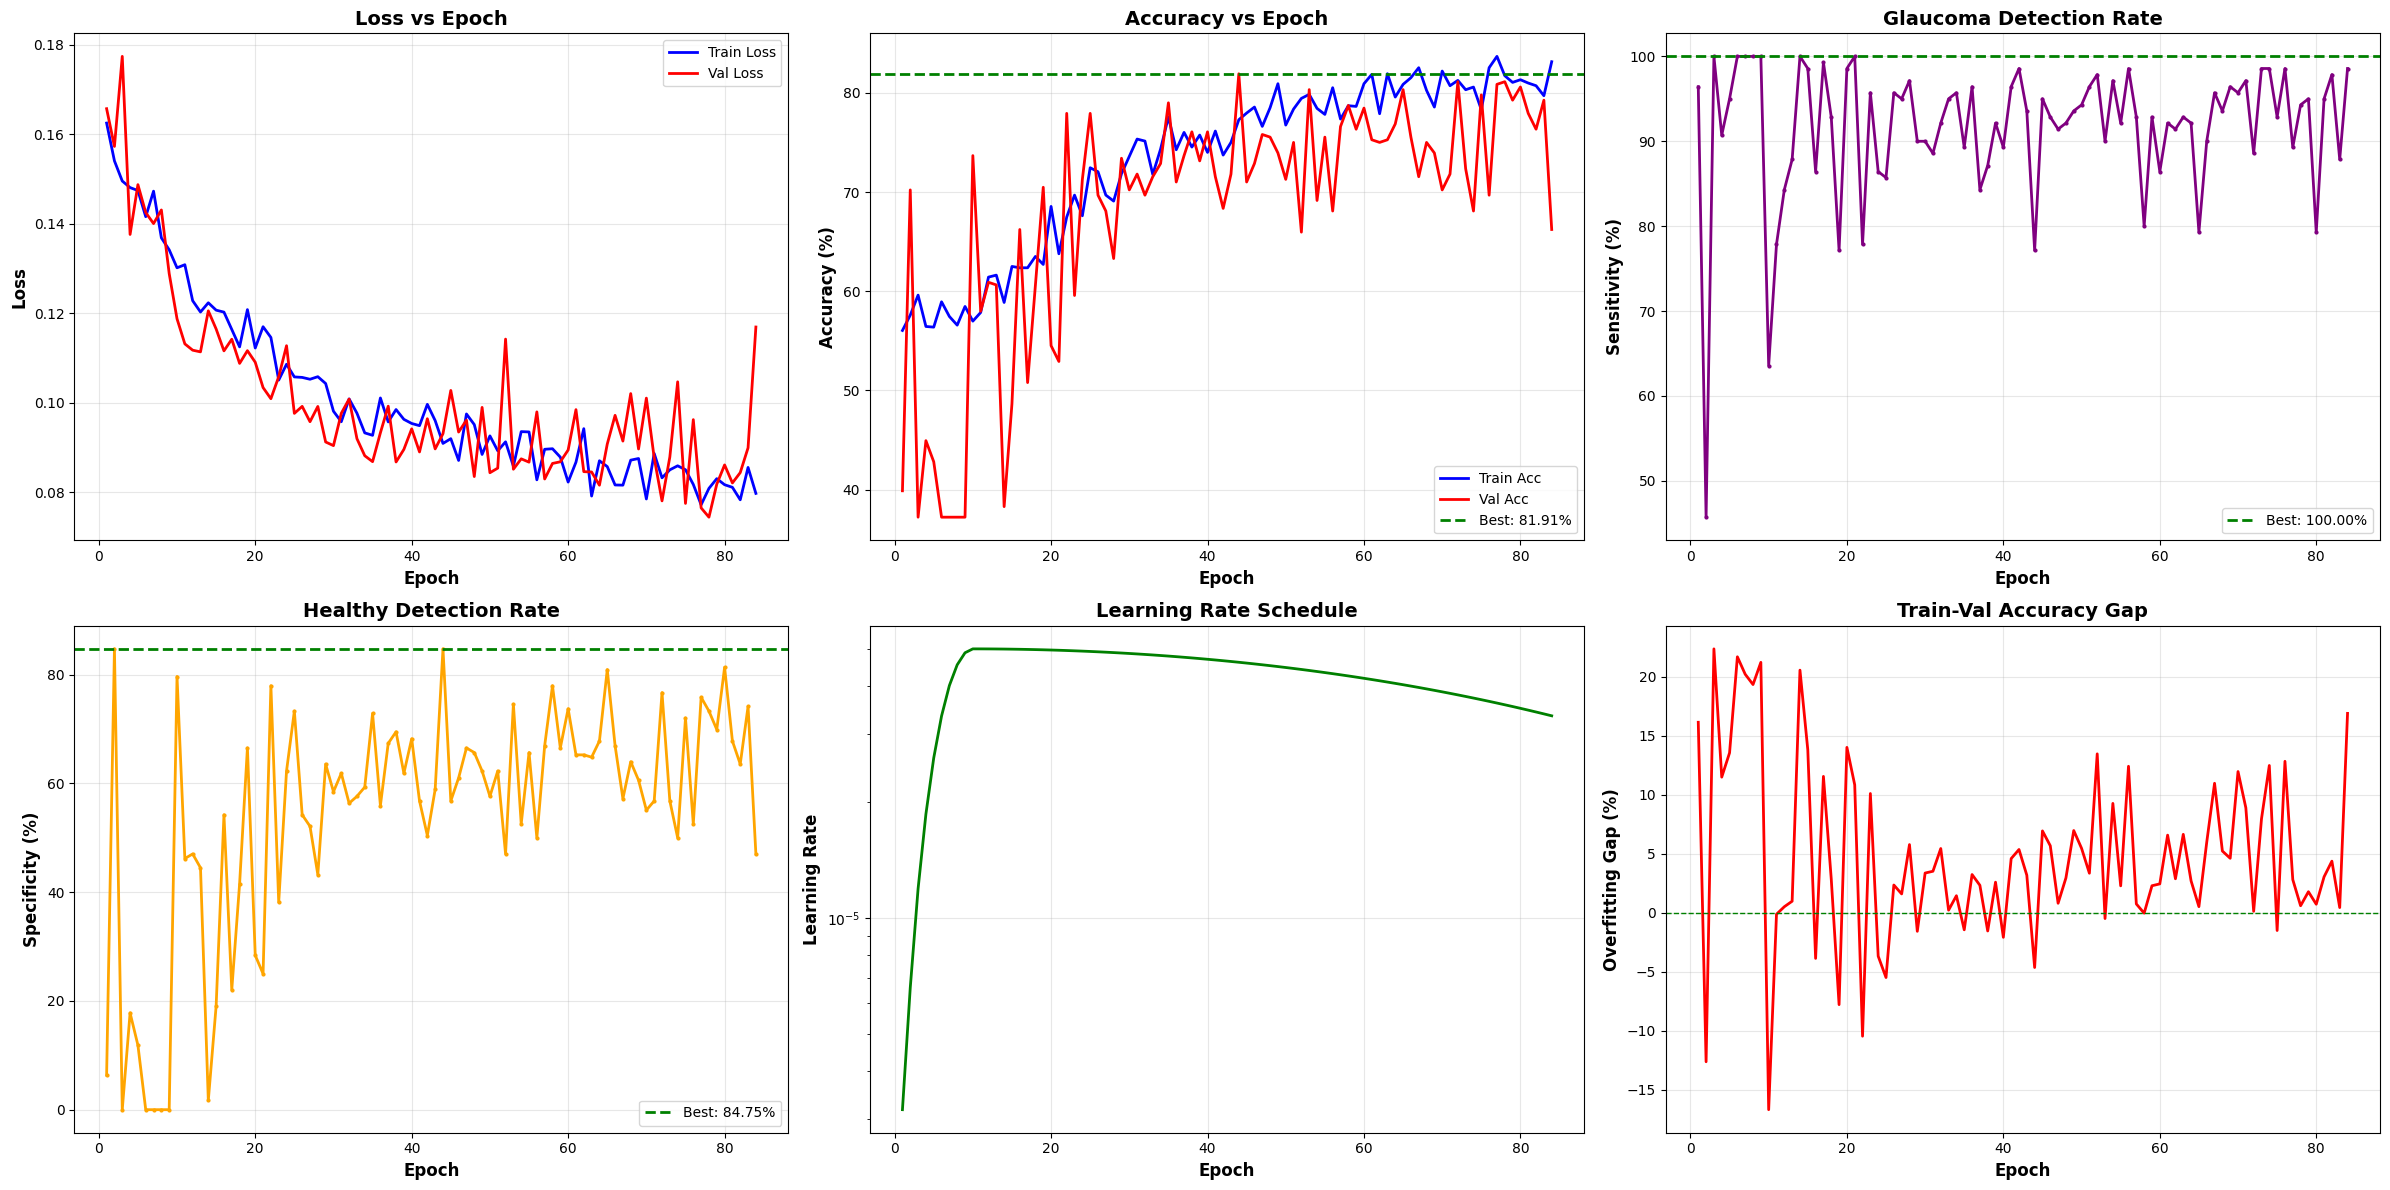


📈 Final Training Statistics:
   Final Train Acc: 83.13%
   Final Val Acc: 66.22%
   Final Sensitivity: 98.57%
   Final Specificity: 47.03%
   Overfitting Gap: 16.91%
   Best Epoch: 44

✅ Ready for evaluation!


In [8]:
# ==================== CNN-ViT HYBRID TRAINING SCRIPT ====================
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm
import math
from torch.optim.lr_scheduler import OneCycleLR, CosineAnnealingWarmRestarts
import warnings
warnings.filterwarnings('ignore')

# ==================== FOCAL LOSS FOR IMBALANCED DATA ====================

class FocalLoss(nn.Module):
    """
    Focal Loss for handling class imbalance
    Paper: "Focal Loss for Dense Object Detection"
    """
    def __init__(self, alpha=None, gamma=2.0, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha  # Class weights
        self.gamma = gamma
        self.reduction = reduction
        
    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none', weight=self.alpha)
        pt = torch.exp(-ce_loss)
        focal_loss = ((1 - pt) ** self.gamma) * ce_loss
        
        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

# ==================== LABEL SMOOTHING ====================

class LabelSmoothingCrossEntropy(nn.Module):
    """Label smoothing to prevent overconfidence"""
    def __init__(self, epsilon=0.1, weight=None):
        super(LabelSmoothingCrossEntropy, self).__init__()
        self.epsilon = epsilon
        self.weight = weight
        
    def forward(self, pred, target):
        n_classes = pred.size(-1)
        log_preds = F.log_softmax(pred, dim=-1)
        
        # Smooth labels
        with torch.no_grad():
            true_dist = torch.zeros_like(log_preds)
            true_dist.fill_(self.epsilon / (n_classes - 1))
            true_dist.scatter_(1, target.unsqueeze(1), 1.0 - self.epsilon)
        
        if self.weight is not None:
            true_dist = true_dist * self.weight.unsqueeze(0)
        
        return torch.mean(torch.sum(-true_dist * log_preds, dim=-1))

# ==================== CONFIGURATION ====================

print("="*80)
print("🚀 CNN-ViT HYBRID MODEL TRAINING")
print("="*80)

# Model configuration
NUM_CLASSES = 2
IMG_SIZE = 384
MODEL_VARIANT = 'base'  # 'small', 'base', or 'large'

# Training hyperparameters
NUM_EPOCHS = 200
BATCH_SIZE = 16  # Already set in dataloader
INITIAL_LR = 5e-5  # Lower LR for stable training
MIN_LR = 1e-7
WEIGHT_DECAY = 0.05  # Higher weight decay for regularization
WARMUP_EPOCHS = 10
GRADIENT_CLIP = 1.0

# Loss configuration
USE_FOCAL_LOSS = True
FOCAL_GAMMA = 2.0
LABEL_SMOOTHING = 0.1

# Early stopping
EARLY_STOPPING_PATIENCE = 40

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"📱 Device: {device}")
if torch.cuda.is_available():
    print(f"🎮 GPU: {torch.cuda.get_device_name(0)}")
    print(f"💾 GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")

# ==================== MODEL INITIALIZATION ====================

print("\n🏗️  Initializing CNN-ViT Hybrid Model...")

if MODEL_VARIANT == 'small':
    model = CNNViTHybrid_Small(num_classes=NUM_CLASSES, img_size=IMG_SIZE)
elif MODEL_VARIANT == 'base':
    model = CNNViTHybrid_Base(num_classes=NUM_CLASSES, img_size=IMG_SIZE)
elif MODEL_VARIANT == 'large':
    model = CNNViTHybrid_Large(num_classes=NUM_CLASSES, img_size=IMG_SIZE)
else:
    raise ValueError(f"Unknown model variant: {MODEL_VARIANT}")

model = model.to(device)

# Model statistics
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"📊 Model: CNN-ViT Hybrid ({MODEL_VARIANT.upper()})")
print(f"   Total parameters: {total_params:,}")
print(f"   Trainable parameters: {trainable_params:,}")

# Multi-GPU support
if torch.cuda.device_count() > 1:
    print(f"🔥 Using {torch.cuda.device_count()} GPUs with DataParallel")
    model = nn.DataParallel(model)

print("="*80)

# ==================== LOSS FUNCTION ====================

if USE_FOCAL_LOSS:
    criterion = FocalLoss(
        alpha=class_weights.to(device),
        gamma=FOCAL_GAMMA,
        reduction='mean'
    )
    print(f"📉 Loss Function: Focal Loss (γ={FOCAL_GAMMA})")
else:
    criterion = LabelSmoothingCrossEntropy(
        epsilon=LABEL_SMOOTHING,
        weight=class_weights.to(device)
    )
    print(f"📉 Loss Function: Label Smoothing CE (ε={LABEL_SMOOTHING})")

# ==================== OPTIMIZER ====================

# Separate learning rates for different components
def get_parameter_groups(model):
    """Create parameter groups with different learning rates"""
    cnn_params = []
    vit_params = []
    head_params = []
    
    for name, param in model.named_parameters():
        if not param.requires_grad:
            continue
        
        if 'cnn_backbone' in name:
            cnn_params.append(param)
        elif 'head' in name:
            head_params.append(param)
        else:
            vit_params.append(param)
    
    return [
        {'params': cnn_params, 'lr': INITIAL_LR * 0.1, 'name': 'cnn'},
        {'params': vit_params, 'lr': INITIAL_LR, 'name': 'vit'},
        {'params': head_params, 'lr': INITIAL_LR * 2.0, 'name': 'head'}
    ]

param_groups = get_parameter_groups(model)

optimizer = optim.AdamW(
    param_groups,
    lr=INITIAL_LR,
    weight_decay=WEIGHT_DECAY,
    betas=(0.9, 0.999),
    eps=1e-8
)

print(f"⚙️  Optimizer: AdamW")
print(f"   CNN LR: {INITIAL_LR * 0.1:.2e}")
print(f"   ViT LR: {INITIAL_LR:.2e}")
print(f"   Head LR: {INITIAL_LR * 2.0:.2e}")
print(f"   Weight Decay: {WEIGHT_DECAY}")

# ==================== LEARNING RATE SCHEDULER ====================

# Calculate total steps
steps_per_epoch = len(train_loader)
total_steps = NUM_EPOCHS * steps_per_epoch
warmup_steps = WARMUP_EPOCHS * steps_per_epoch

scheduler = OneCycleLR(
    optimizer,
    max_lr=[INITIAL_LR * 0.1, INITIAL_LR, INITIAL_LR * 2.0],
    total_steps=total_steps,
    pct_start=WARMUP_EPOCHS/NUM_EPOCHS,
    anneal_strategy='cos',
    div_factor=25.0,
    final_div_factor=1000.0
)

print(f"📅 Scheduler: OneCycleLR with cosine annealing")
print(f"   Warmup epochs: {WARMUP_EPOCHS}")
print(f"   Total steps: {total_steps:,}")

# ==================== MIXED PRECISION & GRADIENT SCALER ====================

scaler = torch.amp.GradScaler('cuda')
print(f"⚡ Mixed Precision: Enabled (FP16)")

# ==================== EARLY STOPPING ====================

class EarlyStopping:
    def __init__(self, patience=25, min_delta=0.0005, mode='max'):
        self.patience = patience
        self.min_delta = min_delta
        self.mode = mode
        self.counter = 0
        self.best_value = None
        self.early_stop = False
        
    def __call__(self, metric):
        if self.best_value is None:
            self.best_value = metric
            return False
        
        if self.mode == 'max':
            improved = metric > (self.best_value + self.min_delta)
        else:
            improved = metric < (self.best_value - self.min_delta)
        
        if improved:
            self.best_value = metric
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        
        return self.early_stop

early_stopping = EarlyStopping(patience=EARLY_STOPPING_PATIENCE, mode='max')

# ==================== TRACKING ====================

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
glaucoma_sensitivities, glaucoma_specificities = [], []
learning_rates = []
best_val_acc = 0.0
best_glaucoma_f1 = 0.0
best_epoch = 0

print("="*80)

# ==================== TRAINING LOOP ====================

print("\n🏋️  Starting Training...")
print("="*80)

for epoch in range(NUM_EPOCHS):
    
    # ===== TRAINING PHASE =====
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    train_pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} [Train]", leave=False)
    
    for batch_idx, (images, labels) in enumerate(train_pbar):
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad(set_to_none=True)
        
        # Mixed precision forward pass
        with torch.amp.autocast('cuda'):
            outputs = model(images)
            loss = criterion(outputs, labels)
        
        # Backward pass with gradient scaling
        scaler.scale(loss).backward()
        
        # Gradient clipping
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=GRADIENT_CLIP)
        
        # Optimizer step
        scaler.step(optimizer)
        scaler.update()
        
        # Scheduler step (per iteration for OneCycleLR)
        scheduler.step()
        
        # Statistics
        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        # Update progress bar
        current_lr = optimizer.param_groups[0]['lr']
        train_pbar.set_postfix({
            'loss': f'{loss.item():.4f}',
            'acc': f'{100.*correct/total:.2f}%',
            'lr': f'{current_lr:.2e}'
        })
    
    train_pbar.close()
    
    train_loss = running_loss / total
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    
    current_lr = optimizer.param_groups[1]['lr']  # ViT LR
    learning_rates.append(current_lr)
    
    # ===== VALIDATION PHASE =====
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    
    # Confusion matrix components
    tp, tn, fp, fn = 0, 0, 0, 0
    
    val_pbar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} [Val]", leave=False)
    
    with torch.no_grad():
        for images, labels in val_pbar:
            images, labels = images.to(device), labels.to(device)
            
            with torch.amp.autocast('cuda'):
                outputs = model(images)
                loss = criterion(outputs, labels)
            
            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
            
            # Calculate confusion matrix components
            tp += ((predicted == 1) & (labels == 1)).sum().item()
            tn += ((predicted == 0) & (labels == 0)).sum().item()
            fp += ((predicted == 1) & (labels == 0)).sum().item()
            fn += ((predicted == 0) & (labels == 1)).sum().item()
            
            val_pbar.set_postfix({
                'loss': f'{loss.item():.4f}',
                'acc': f'{100.*val_correct/val_total:.2f}%'
            })
    
    val_pbar.close()
    
    val_loss /= val_total
    val_acc = val_correct / val_total
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    
    # Calculate medical metrics
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0.0  # Glaucoma detection rate
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0  # Healthy detection rate
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
    f1_glaucoma = 2 * (precision * sensitivity) / (precision + sensitivity) if (precision + sensitivity) > 0 else 0.0
    
    glaucoma_sensitivities.append(sensitivity)
    glaucoma_specificities.append(specificity)
    
    # ===== MODEL CHECKPOINTING =====
    improvement = ""
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_glaucoma_f1 = f1_glaucoma
        best_epoch = epoch + 1
        
        # Save best model
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'val_acc': val_acc,
            'val_loss': val_loss,
            'sensitivity': sensitivity,
            'specificity': specificity,
            'f1_score': f1_glaucoma,
            'config': {
                'model_variant': MODEL_VARIANT,
                'img_size': IMG_SIZE,
                'num_classes': NUM_CLASSES
            }
        }, "best_hybrid_glaucoma.pth")
        
        improvement = "✅ NEW BEST!"
    
    # ===== LOGGING =====
    print(f"Epoch [{epoch+1:3d}/{NUM_EPOCHS}] "
          f"Train: Loss={train_loss:.4f}, Acc={train_acc:.4f} | "
          f"Val: Loss={val_loss:.4f}, Acc={val_acc:.4f} | "
          f"Sens={sensitivity:.4f}, Spec={specificity:.4f}, F1={f1_glaucoma:.4f} | "
          f"LR={current_lr:.2e} {improvement}")
    
    # ===== EARLY STOPPING =====
    if early_stopping(val_acc):
        print(f"\n⚠️  Early stopping triggered at epoch {epoch+1}")
        print(f"   Best Val Acc: {best_val_acc:.4f} at epoch {best_epoch}")
        print(f"   Best F1-Score: {best_glaucoma_f1:.4f}")
        break

# ==================== SAVE FINAL MODEL ====================

torch.save({
    'epoch': epoch + 1,
    'model_state_dict': model.state_dict(),
    'train_losses': train_losses,
    'val_losses': val_losses,
    'train_accuracies': train_accuracies,
    'val_accuracies': val_accuracies,
    'sensitivities': glaucoma_sensitivities,
    'specificities': glaucoma_specificities,
    'learning_rates': learning_rates,
    'config': {
        'model_variant': MODEL_VARIANT,
        'img_size': IMG_SIZE,
        'num_classes': NUM_CLASSES
    }
}, "final_hybrid_glaucoma.pth")

# ==================== TRAINING SUMMARY ====================

print("\n" + "="*80)
print("🎉 TRAINING COMPLETE!")
print("="*80)
print(f"✅ Best Validation Accuracy: {best_val_acc:.4f} ({best_val_acc*100:.2f}%) at epoch {best_epoch}")
print(f"✅ Best Glaucoma F1-Score: {best_glaucoma_f1:.4f}")
print(f"✅ Final Sensitivity: {glaucoma_sensitivities[-1]:.4f}")
print(f"✅ Final Specificity: {glaucoma_specificities[-1]:.4f}")
print(f"✅ Total Epochs Trained: {len(train_losses)}")
print(f"✅ Model saved: best_hybrid_glaucoma.pth")
print("="*80)

# ==================== VISUALIZATION ====================

fig = plt.figure(figsize=(24, 12))

# Loss curves
ax1 = plt.subplot(2, 3, 1)
epochs_range = range(1, len(train_losses) + 1)
ax1.plot(epochs_range, train_losses, 'b-', label='Train Loss', linewidth=2)
ax1.plot(epochs_range, val_losses, 'r-', label='Val Loss', linewidth=2)
ax1.set_xlabel('Epoch', fontsize=12, fontweight='bold')
ax1.set_ylabel('Loss', fontsize=12, fontweight='bold')
ax1.set_title('Loss vs Epoch', fontsize=14, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# Accuracy curves
ax2 = plt.subplot(2, 3, 2)
ax2.plot(epochs_range, [acc*100 for acc in train_accuracies], 'b-', label='Train Acc', linewidth=2)
ax2.plot(epochs_range, [acc*100 for acc in val_accuracies], 'r-', label='Val Acc', linewidth=2)
ax2.axhline(y=best_val_acc*100, color='g', linestyle='--', linewidth=2, label=f'Best: {best_val_acc*100:.2f}%')
ax2.set_xlabel('Epoch', fontsize=12, fontweight='bold')
ax2.set_ylabel('Accuracy (%)', fontsize=12, fontweight='bold')
ax2.set_title('Accuracy vs Epoch', fontsize=14, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)

# Sensitivity (Glaucoma detection)
ax3 = plt.subplot(2, 3, 3)
ax3.plot(epochs_range, [s*100 for s in glaucoma_sensitivities], 'purple', linewidth=2, marker='o', markersize=2)
ax3.axhline(y=np.max(glaucoma_sensitivities)*100, color='g', linestyle='--', linewidth=2, 
            label=f'Best: {np.max(glaucoma_sensitivities)*100:.2f}%')
ax3.set_xlabel('Epoch', fontsize=12, fontweight='bold')
ax3.set_ylabel('Sensitivity (%)', fontsize=12, fontweight='bold')
ax3.set_title('Glaucoma Detection Rate', fontsize=14, fontweight='bold')
ax3.legend(fontsize=10)
ax3.grid(True, alpha=0.3)

# Specificity (Healthy detection)
ax4 = plt.subplot(2, 3, 4)
ax4.plot(epochs_range, [s*100 for s in glaucoma_specificities], 'orange', linewidth=2, marker='o', markersize=2)
ax4.axhline(y=np.max(glaucoma_specificities)*100, color='g', linestyle='--', linewidth=2,
            label=f'Best: {np.max(glaucoma_specificities)*100:.2f}%')
ax4.set_xlabel('Epoch', fontsize=12, fontweight='bold')
ax4.set_ylabel('Specificity (%)', fontsize=12, fontweight='bold')
ax4.set_title('Healthy Detection Rate', fontsize=14, fontweight='bold')
ax4.legend(fontsize=10)
ax4.grid(True, alpha=0.3)

# Learning rate schedule
ax5 = plt.subplot(2, 3, 5)
ax5.plot(epochs_range, learning_rates, 'green', linewidth=2)
ax5.set_xlabel('Epoch', fontsize=12, fontweight='bold')
ax5.set_ylabel('Learning Rate', fontsize=12, fontweight='bold')
ax5.set_title('Learning Rate Schedule', fontsize=14, fontweight='bold')
ax5.set_yscale('log')
ax5.grid(True, alpha=0.3)

# Overfitting analysis
ax6 = plt.subplot(2, 3, 6)
overfitting_gap = [(train_accuracies[i] - val_accuracies[i])*100 for i in range(len(train_accuracies))]
ax6.plot(epochs_range, overfitting_gap, 'red', linewidth=2)
ax6.axhline(y=0, color='green', linestyle='--', linewidth=1)
ax6.set_xlabel('Epoch', fontsize=12, fontweight='bold')
ax6.set_ylabel('Overfitting Gap (%)', fontsize=12, fontweight='bold')
ax6.set_title('Train-Val Accuracy Gap', fontsize=14, fontweight='bold')
ax6.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('hybrid_training_curves.png', dpi=300, bbox_inches='tight')
print(f"\n📊 Training curves saved: hybrid_training_curves.png")
plt.show()

# ==================== FINAL STATISTICS ====================

print("\n📈 Final Training Statistics:")
print(f"   Final Train Acc: {train_accuracies[-1]*100:.2f}%")
print(f"   Final Val Acc: {val_accuracies[-1]*100:.2f}%")
print(f"   Final Sensitivity: {glaucoma_sensitivities[-1]*100:.2f}%")
print(f"   Final Specificity: {glaucoma_specificities[-1]*100:.2f}%")
print(f"   Overfitting Gap: {overfitting_gap[-1]:.2f}%")
print(f"   Best Epoch: {best_epoch}")

print("\n" + "="*80)
print("✅ Ready for evaluation!")
print("="*80)

# Load & Test Model

🔬 CNN-ViT HYBRID MODEL - COMPREHENSIVE EVALUATION
📱 Device: cuda

🔧 Loading CNN-ViT Hybrid Model...
📂 Loading checkpoint: best_hybrid_glaucoma.pth

📊 Checkpoint Information:
   Epoch: 44
   Val Accuracy: 0.8191 (81.91%)
   Val Loss: 0.0931
   Sensitivity: 0.7714
   Specificity: 0.8475
   F1-Score: 0.7606
✅ Model loaded successfully!

🧪 Running Comprehensive Evaluation...
   Using Test-Time Augmentation (3 transforms)


Evaluating: 100%|██████████| 24/24 [00:19<00:00,  1.23it/s]



✅ Overall Accuracy: 81.12%

📊 DETAILED CLASSIFICATION REPORT
              precision    recall  f1-score   support

     Healthy     0.8571    0.8390    0.8480       236
    Glaucoma     0.7379    0.7643    0.7509       140

    accuracy                         0.8112       376
   macro avg     0.7975    0.8016    0.7994       376
weighted avg     0.8128    0.8112    0.8118       376


💾 Confusion matrices saved: hybrid_confusion_matrix.png


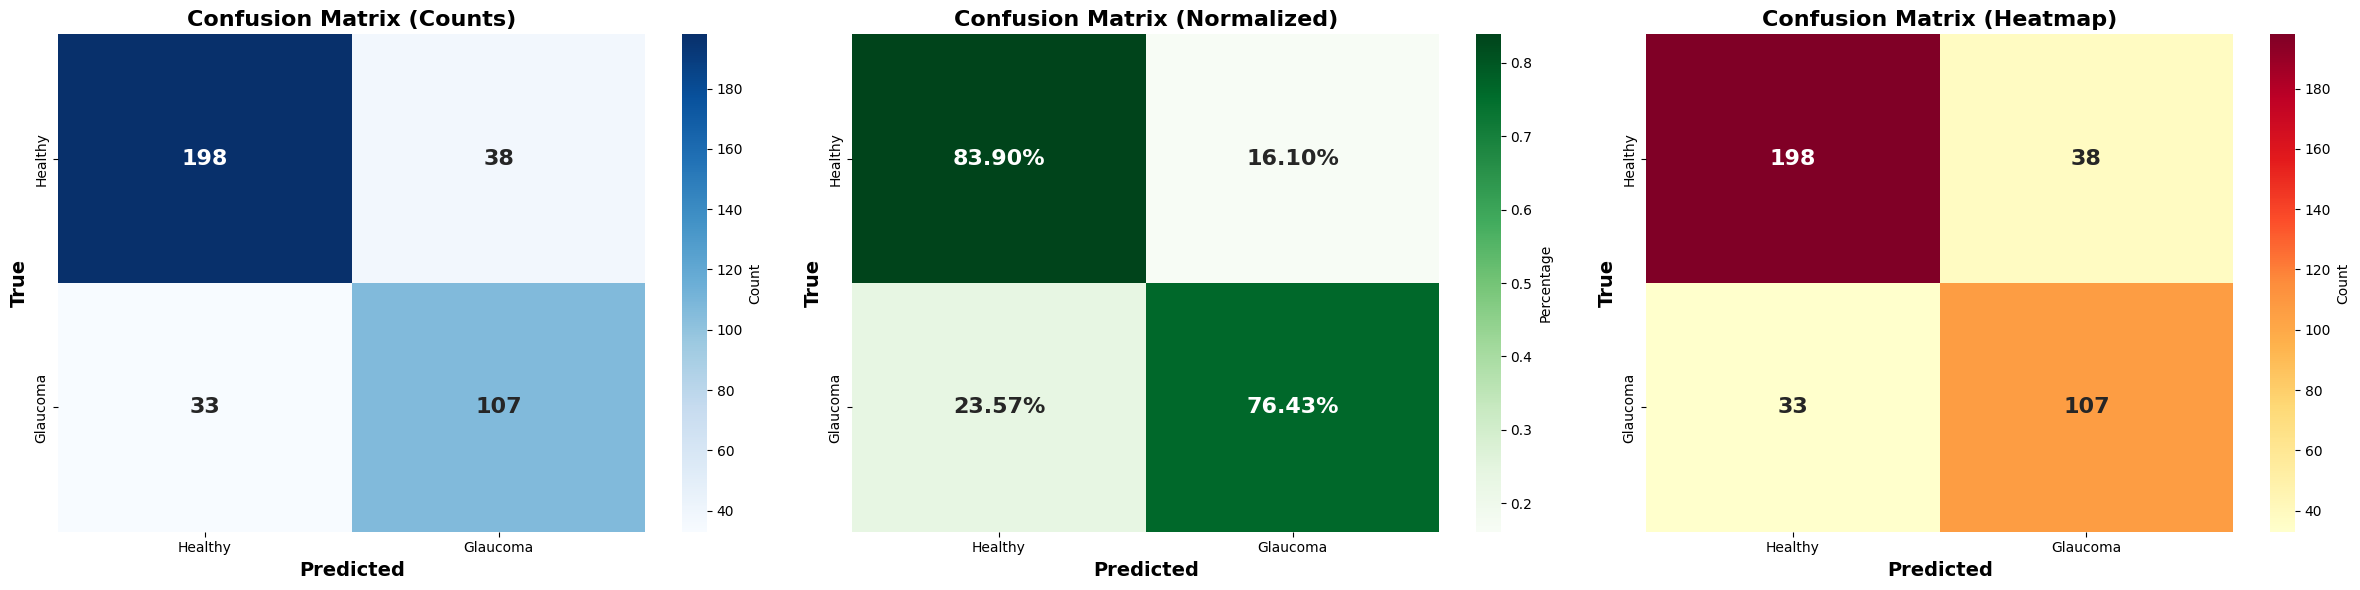


📈 PER-CLASS PERFORMANCE
Healthy        : Accuracy =  83.90% | Total =  236 samples
Glaucoma       : Accuracy =  76.43% | Total =  140 samples
💾 ROC and PR curves saved: hybrid_roc_pr_curves.png


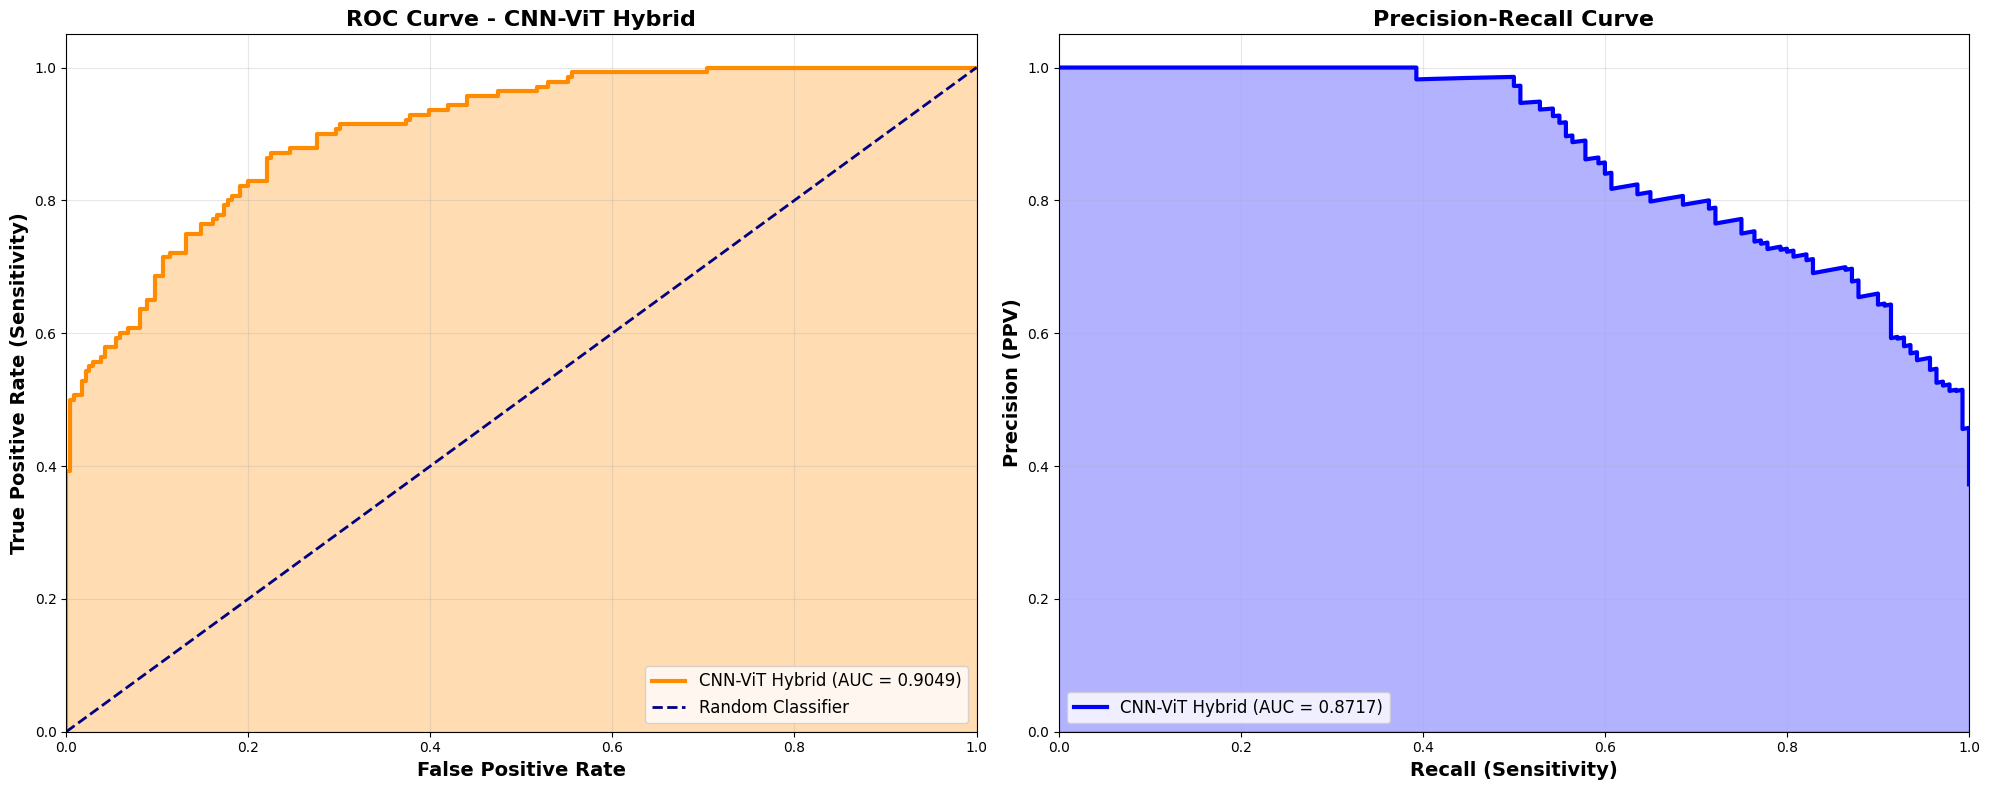


🎯 OPTIMAL THRESHOLD ANALYSIS

Youden's J Statistic:
   Optimal Threshold: 0.4386
   True Positive Rate (Sensitivity): 0.8714 (87.14%)
   False Positive Rate: 0.2246 (22.46%)
   Specificity: 0.7754 (77.54%)

F1-Score Optimization:
   Optimal Threshold: 0.4343
   F1-Score: 0.7746

⚕️  COMPREHENSIVE MEDICAL METRICS

🔍 Diagnostic Performance:
   Sensitivity (Recall, TPR):           0.7643 (76.43%)
   Specificity (TNR):                   0.8390 (83.90%)
   Balanced Accuracy:                   0.8016 (80.16%)

🎯 Predictive Values:
   Precision (PPV):                     0.7379 (73.79%)
   Negative Predictive Value (NPV):     0.8571 (85.71%)

📊 Composite Metrics:
   F1-Score:                            0.7509
   Matthews Correlation Coefficient:    0.5992
   ROC-AUC:                             0.9049
   PR-AUC:                              0.8717

💡 Likelihood Ratios:
   Positive Likelihood Ratio (LR+):     4.75
   Negative Likelihood Ratio (LR-):     0.2810

🔢 Confusion Matrix Breakdown:
 

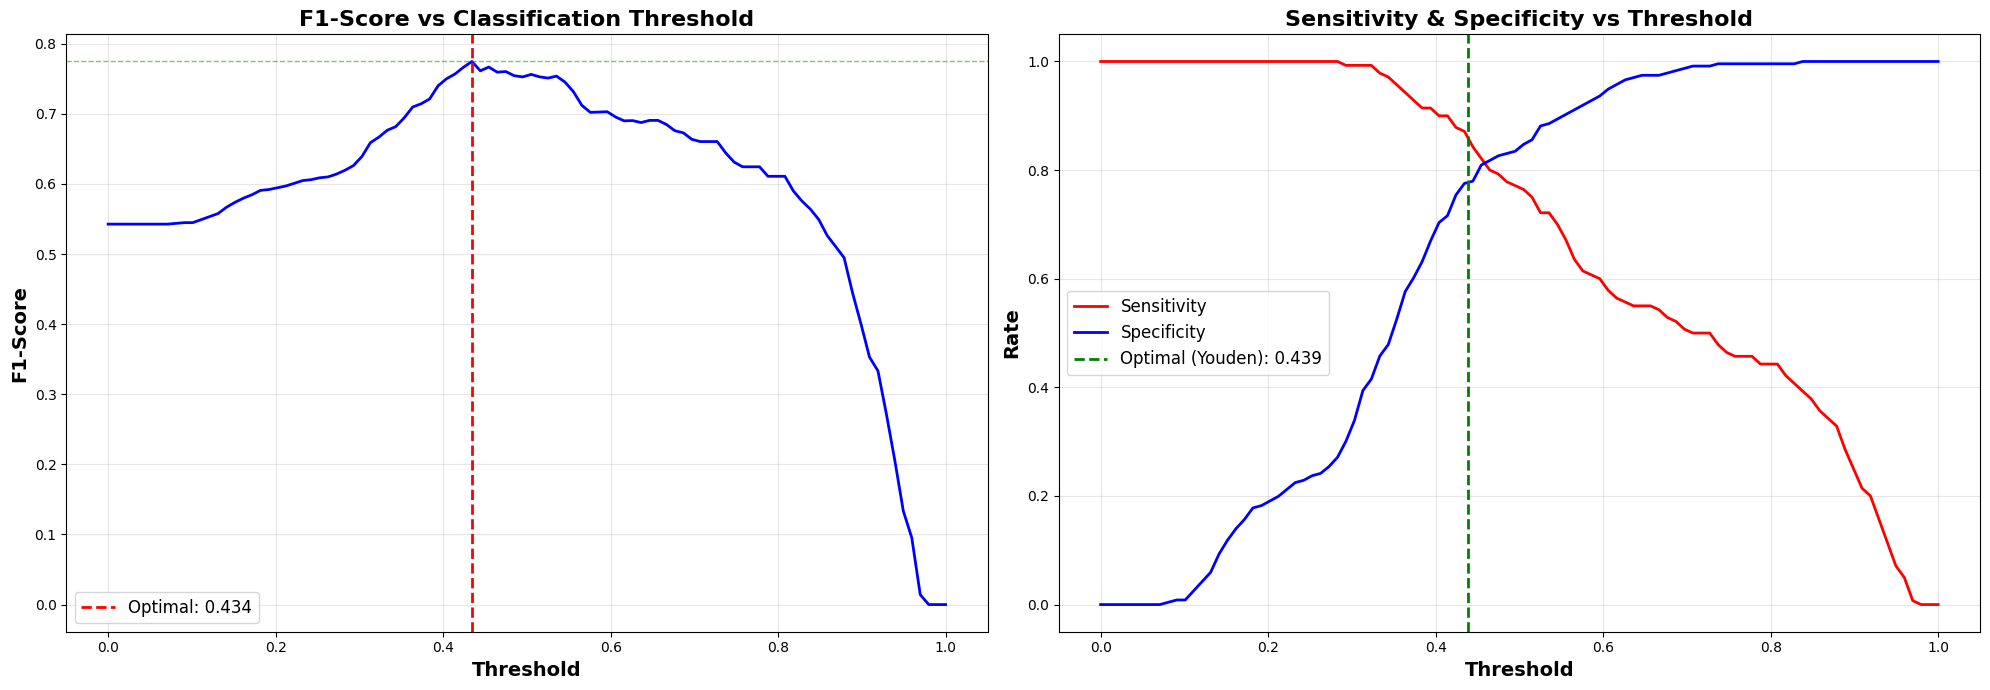


📋 CNN-ViT HYBRID MODEL - EVALUATION SUMMARY

🎯 Performance Metrics:
   Overall Accuracy:        81.12%
   Balanced Accuracy:       80.16%
   Sensitivity (Glaucoma):  76.43%
   Specificity (Healthy):   83.90%
   F1-Score:                0.7509
   ROC-AUC:                 0.9049
   PR-AUC:                  0.8717
   MCC:                     0.5992

🔢 Classification Results:
   True Positives:          107
   True Negatives:          198
   False Positives:         38
   False Negatives:         33
   Total Samples:           376

💡 Clinical Utility:
   Test-Time Augmentation:  Enabled
   Optimal Threshold:       0.4386
   Recommended for:         Further Development ⚠️

✅ EVALUATION COMPLETE!


In [9]:
# ==================== CNN-ViT HYBRID EVALUATION SCRIPT ====================
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import (classification_report, confusion_matrix, roc_curve, 
                            auc, precision_recall_curve, f1_score, matthews_corrcoef)
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from collections import OrderedDict
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

print("="*80)
print("🔬 CNN-ViT HYBRID MODEL - COMPREHENSIVE EVALUATION")
print("="*80)

# ==================== CONFIGURATION ====================

classes = ['Healthy', 'Glaucoma']
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"📱 Device: {device}")

# Test-Time Augmentation (TTA) settings
USE_TTA = True
TTA_TRANSFORMS = 3  # Number of augmentations

# ==================== LOAD MODEL ====================

print(f"\n🔧 Loading CNN-ViT Hybrid Model...")

# Initialize model (adjust variant based on your training)
model = CNNViTHybrid_Base(num_classes=2, img_size=384).to(device)

checkpoint_path = "best_hybrid_glaucoma.pth"
print(f"📂 Loading checkpoint: {checkpoint_path}")

try:
    checkpoint = torch.load(checkpoint_path, map_location=device, weights_only=False)
    
    if isinstance(checkpoint, dict) and 'model_state_dict' in checkpoint:
        state_dict = checkpoint['model_state_dict']
        
        print(f"\n📊 Checkpoint Information:")
        print(f"   Epoch: {checkpoint.get('epoch', 'N/A')}")
        print(f"   Val Accuracy: {checkpoint.get('val_acc', 0):.4f} ({checkpoint.get('val_acc', 0)*100:.2f}%)")
        print(f"   Val Loss: {checkpoint.get('val_loss', 'N/A'):.4f}")
        print(f"   Sensitivity: {checkpoint.get('sensitivity', 0):.4f}")
        print(f"   Specificity: {checkpoint.get('specificity', 0):.4f}")
        print(f"   F1-Score: {checkpoint.get('f1_score', 0):.4f}")
    else:
        state_dict = checkpoint
    
    # Remove 'module.' prefix if trained with DataParallel
    new_state_dict = OrderedDict()
    for k, v in state_dict.items():
        name = k.replace("module.", "")
        new_state_dict[name] = v
    
    model.load_state_dict(new_state_dict, strict=False)
    model.eval()
    print("✅ Model loaded successfully!")
    
except FileNotFoundError:
    print(f"❌ Error: Model file '{checkpoint_path}' not found!")
    print("   Please ensure you've trained the model first.")
    exit()
except Exception as e:
    print(f"❌ Error loading model: {e}")
    exit()

print("="*80)

# ==================== TEST-TIME AUGMENTATION (TTA) ====================

def predict_with_tta(model, images, device):
    """
    Perform Test-Time Augmentation for robust predictions
    """
    model.eval()
    predictions = []
    
    with torch.no_grad():
        # Original image
        with torch.amp.autocast('cuda'):
            outputs = model(images)
            probs = F.softmax(outputs, dim=1)
            predictions.append(probs)
        
        # Horizontal flip
        images_hflip = torch.flip(images, dims=[3])
        with torch.amp.autocast('cuda'):
            outputs = model(images_hflip)
            probs = F.softmax(outputs, dim=1)
            predictions.append(probs)
        
        # Vertical flip
        images_vflip = torch.flip(images, dims=[2])
        with torch.amp.autocast('cuda'):
            outputs = model(images_vflip)
            probs = F.softmax(outputs, dim=1)
            predictions.append(probs)
    
    # Average predictions
    avg_probs = torch.stack(predictions).mean(dim=0)
    return avg_probs

# ==================== EVALUATION ====================

print("\n🧪 Running Comprehensive Evaluation...")
if USE_TTA:
    print(f"   Using Test-Time Augmentation ({TTA_TRANSFORMS} transforms)")

all_preds = []
all_labels = []
all_probs = []

model.eval()

with torch.no_grad():
    correct = 0
    total = 0
    
    for images, labels in tqdm(val_loader, desc="Evaluating"):
        images, labels = images.to(device), labels.to(device)
        
        # Get predictions
        if USE_TTA:
            probs = predict_with_tta(model, images, device)
        else:
            with torch.amp.autocast('cuda'):
                outputs = model(images)
                probs = F.softmax(outputs, dim=1)
        
        _, predicted = torch.max(probs, 1)
        
        # Store results
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs[:, 1].cpu().numpy())
        
        # Calculate accuracy
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

# ==================== OVERALL METRICS ====================

overall_accuracy = correct / total
print(f"\n✅ Overall Accuracy: {overall_accuracy * 100:.2f}%")

# Classification Report
print("\n" + "="*80)
print("📊 DETAILED CLASSIFICATION REPORT")
print("="*80)
report = classification_report(all_labels, all_preds, target_names=classes, digits=4)
print(report)

# ==================== CONFUSION MATRIX ====================

cm = confusion_matrix(all_labels, all_preds)

fig, axes = plt.subplots(1, 3, figsize=(24, 6))

# Confusion Matrix (Counts)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=classes, yticklabels=classes,
            cbar_kws={'label': 'Count'}, ax=axes[0],
            annot_kws={'size': 16, 'weight': 'bold'})
axes[0].set_xlabel("Predicted", fontsize=14, fontweight='bold')
axes[0].set_ylabel("True", fontsize=14, fontweight='bold')
axes[0].set_title("Confusion Matrix (Counts)", fontsize=16, fontweight='bold')

# Confusion Matrix (Normalized)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_normalized, annot=True, fmt=".2%", cmap="Greens",
            xticklabels=classes, yticklabels=classes,
            cbar_kws={'label': 'Percentage'}, ax=axes[1],
            annot_kws={'size': 16, 'weight': 'bold'})
axes[1].set_xlabel("Predicted", fontsize=14, fontweight='bold')
axes[1].set_ylabel("True", fontsize=14, fontweight='bold')
axes[1].set_title("Confusion Matrix (Normalized)", fontsize=16, fontweight='bold')

# Confusion Matrix (Heatmap style)
sns.heatmap(cm, annot=True, fmt="d", cmap="YlOrRd",
            xticklabels=classes, yticklabels=classes,
            cbar_kws={'label': 'Count'}, ax=axes[2],
            annot_kws={'size': 16, 'weight': 'bold'})
axes[2].set_xlabel("Predicted", fontsize=14, fontweight='bold')
axes[2].set_ylabel("True", fontsize=14, fontweight='bold')
axes[2].set_title("Confusion Matrix (Heatmap)", fontsize=16, fontweight='bold')

plt.tight_layout()
plt.savefig('hybrid_confusion_matrix.png', dpi=300, bbox_inches='tight')
print("\n💾 Confusion matrices saved: hybrid_confusion_matrix.png")
plt.show()

# ==================== PER-CLASS PERFORMANCE ====================

print("\n" + "="*80)
print("📈 PER-CLASS PERFORMANCE")
print("="*80)

cm_diag = np.diag(cm)
class_counts = cm.sum(axis=1)

for i, cls in enumerate(classes):
    class_acc = cm_diag[i] / class_counts[i] * 100
    print(f"{cls:15s}: Accuracy = {class_acc:6.2f}% | Total = {class_counts[i]:4d} samples")

# ==================== ROC AND PR CURVES ====================

# ROC Curve
fpr, tpr, roc_thresholds = roc_curve(all_labels, all_probs)
roc_auc = auc(fpr, tpr)

# Precision-Recall Curve
precision, recall, pr_thresholds = precision_recall_curve(all_labels, all_probs)
pr_auc = auc(recall, precision)

# Plot
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# ROC Curve
axes[0].plot(fpr, tpr, color='darkorange', lw=3,
             label=f'CNN-ViT Hybrid (AUC = {roc_auc:.4f})')
axes[0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
axes[0].fill_between(fpr, tpr, alpha=0.3, color='darkorange')
axes[0].set_xlim([0.0, 1.0])
axes[0].set_ylim([0.0, 1.05])
axes[0].set_xlabel('False Positive Rate', fontsize=14, fontweight='bold')
axes[0].set_ylabel('True Positive Rate (Sensitivity)', fontsize=14, fontweight='bold')
axes[0].set_title('ROC Curve - CNN-ViT Hybrid', fontsize=16, fontweight='bold')
axes[0].legend(loc="lower right", fontsize=12)
axes[0].grid(True, alpha=0.3)

# Precision-Recall Curve
axes[1].plot(recall, precision, color='blue', lw=3,
             label=f'CNN-ViT Hybrid (AUC = {pr_auc:.4f})')
axes[1].fill_between(recall, precision, alpha=0.3, color='blue')
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlabel('Recall (Sensitivity)', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Precision (PPV)', fontsize=14, fontweight='bold')
axes[1].set_title('Precision-Recall Curve', fontsize=16, fontweight='bold')
axes[1].legend(loc="lower left", fontsize=12)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('hybrid_roc_pr_curves.png', dpi=300, bbox_inches='tight')
print("💾 ROC and PR curves saved: hybrid_roc_pr_curves.png")
plt.show()

# ==================== OPTIMAL THRESHOLD ANALYSIS ====================

print("\n" + "="*80)
print("🎯 OPTIMAL THRESHOLD ANALYSIS")
print("="*80)

# Youden's J statistic
j_scores = tpr - fpr
optimal_idx = np.argmax(j_scores)
optimal_threshold = roc_thresholds[optimal_idx]
optimal_tpr = tpr[optimal_idx]
optimal_fpr = fpr[optimal_idx]

print(f"\nYouden's J Statistic:")
print(f"   Optimal Threshold: {optimal_threshold:.4f}")
print(f"   True Positive Rate (Sensitivity): {optimal_tpr:.4f} ({optimal_tpr*100:.2f}%)")
print(f"   False Positive Rate: {optimal_fpr:.4f} ({optimal_fpr*100:.2f}%)")
print(f"   Specificity: {1-optimal_fpr:.4f} ({(1-optimal_fpr)*100:.2f}%)")

# F1-Score based threshold
f1_scores = []
thresholds_for_f1 = np.linspace(0, 1, 100)
for thresh in thresholds_for_f1:
    preds_thresh = (np.array(all_probs) >= thresh).astype(int)
    f1 = f1_score(all_labels, preds_thresh)
    f1_scores.append(f1)

optimal_f1_idx = np.argmax(f1_scores)
optimal_f1_threshold = thresholds_for_f1[optimal_f1_idx]
optimal_f1 = f1_scores[optimal_f1_idx]

print(f"\nF1-Score Optimization:")
print(f"   Optimal Threshold: {optimal_f1_threshold:.4f}")
print(f"   F1-Score: {optimal_f1:.4f}")

# ==================== COMPREHENSIVE MEDICAL METRICS ====================

print("\n" + "="*80)
print("⚕️  COMPREHENSIVE MEDICAL METRICS")
print("="*80)

tn, fp, fn, tp = cm.ravel()

# Core metrics
sensitivity = tp / (tp + fn)  # Recall, True Positive Rate
specificity = tn / (tn + fp)  # True Negative Rate
precision_val = tp / (tp + fp) if (tp + fp) > 0 else 0  # Positive Predictive Value
npv = tn / (tn + fn) if (tn + fn) > 0 else 0  # Negative Predictive Value

# Additional metrics
f1_score_val = 2 * (precision_val * sensitivity) / (precision_val + sensitivity) if (precision_val + sensitivity) > 0 else 0
balanced_accuracy = (sensitivity + specificity) / 2
mcc = matthews_corrcoef(all_labels, all_preds)  # Matthews Correlation Coefficient

# Likelihood ratios
lr_positive = sensitivity / (1 - specificity) if specificity < 1 else float('inf')
lr_negative = (1 - sensitivity) / specificity if specificity > 0 else float('inf')

print(f"\n🔍 Diagnostic Performance:")
print(f"   Sensitivity (Recall, TPR):           {sensitivity:.4f} ({sensitivity*100:.2f}%)")
print(f"   Specificity (TNR):                   {specificity:.4f} ({specificity*100:.2f}%)")
print(f"   Balanced Accuracy:                   {balanced_accuracy:.4f} ({balanced_accuracy*100:.2f}%)")

print(f"\n🎯 Predictive Values:")
print(f"   Precision (PPV):                     {precision_val:.4f} ({precision_val*100:.2f}%)")
print(f"   Negative Predictive Value (NPV):     {npv:.4f} ({npv*100:.2f}%)")

print(f"\n📊 Composite Metrics:")
print(f"   F1-Score:                            {f1_score_val:.4f}")
print(f"   Matthews Correlation Coefficient:    {mcc:.4f}")
print(f"   ROC-AUC:                             {roc_auc:.4f}")
print(f"   PR-AUC:                              {pr_auc:.4f}")

print(f"\n💡 Likelihood Ratios:")
print(f"   Positive Likelihood Ratio (LR+):     {lr_positive:.2f}")
print(f"   Negative Likelihood Ratio (LR-):     {lr_negative:.4f}")

print(f"\n🔢 Confusion Matrix Breakdown:")
print(f"   True Positives (TP):                 {tp:4d}")
print(f"   True Negatives (TN):                 {tn:4d}")
print(f"   False Positives (FP):                {fp:4d}")
print(f"   False Negatives (FN):                {fn:4d}")

# ==================== CLINICAL INTERPRETATION ====================

print("\n" + "="*80)
print("🏥 CLINICAL INTERPRETATION")
print("="*80)

print(f"\n🔬 Glaucoma Detection Performance:")
if sensitivity >= 0.95:
    print(f"   ⭐⭐⭐ EXCELLENT sensitivity ({sensitivity*100:.1f}%)")
    print(f"   → Model detects {tp} out of {tp+fn} glaucoma cases")
    print(f"   → Only {fn} cases missed (very low false negative rate)")
elif sensitivity >= 0.90:
    print(f"   ⭐⭐ VERY GOOD sensitivity ({sensitivity*100:.1f}%)")
    print(f"   → Suitable for clinical screening")
    print(f"   → {fn} glaucoma cases missed")
elif sensitivity >= 0.85:
    print(f"   ⭐ GOOD sensitivity ({sensitivity*100:.1f}%)")
    print(f"   → Acceptable for assisted diagnosis")
    print(f"   → Consider improving to reduce {fn} missed cases")
else:
    print(f"   ⚠️  MODERATE sensitivity ({sensitivity*100:.1f}%)")
    print(f"   → {fn} glaucoma cases missed - needs improvement")

print(f"\n✅ Healthy Classification Performance:")
if specificity >= 0.95:
    print(f"   ⭐⭐⭐ EXCELLENT specificity ({specificity*100:.1f}%)")
    print(f"   → Very few false alarms ({fp} false positives)")
elif specificity >= 0.90:
    print(f"   ⭐⭐ VERY GOOD specificity ({specificity*100:.1f}%)")
    print(f"   → Acceptable false alarm rate")
elif specificity >= 0.85:
    print(f"   ⭐ GOOD specificity ({specificity*100:.1f}%)")
    print(f"   → {fp} false alarms may need attention")
else:
    print(f"   ⚠️  MODERATE specificity ({specificity*100:.1f}%)")
    print(f"   → High false alarm rate ({fp} false positives)")

print(f"\n💯 Overall Assessment:")
if balanced_accuracy >= 0.95:
    print(f"   ⭐⭐⭐ OUTSTANDING performance ({balanced_accuracy*100:.1f}%)")
    print(f"   → Excellent balance between sensitivity and specificity")
    print(f"   → Ready for clinical validation studies")
elif balanced_accuracy >= 0.90:
    print(f"   ⭐⭐ EXCELLENT performance ({balanced_accuracy*100:.1f}%)")
    print(f"   → Strong performance on both classes")
    print(f"   → Suitable for clinical assistance")
elif balanced_accuracy >= 0.85:
    print(f"   ⭐ VERY GOOD performance ({balanced_accuracy*100:.1f}%)")
    print(f"   → Reliable for screening purposes")
else:
    print(f"   ✅ GOOD performance ({balanced_accuracy*100:.1f}%)")
    print(f"   → Room for improvement")

# ==================== THRESHOLD VISUALIZATION ====================

fig, axes = plt.subplots(1, 2, figsize=(20, 7))

# F1-Score vs Threshold
axes[0].plot(thresholds_for_f1, f1_scores, 'b-', linewidth=2)
axes[0].axvline(optimal_f1_threshold, color='r', linestyle='--', linewidth=2, 
                label=f'Optimal: {optimal_f1_threshold:.3f}')
axes[0].axhline(optimal_f1, color='g', linestyle='--', linewidth=1, alpha=0.5)
axes[0].set_xlabel('Threshold', fontsize=14, fontweight='bold')
axes[0].set_ylabel('F1-Score', fontsize=14, fontweight='bold')
axes[0].set_title('F1-Score vs Classification Threshold', fontsize=16, fontweight='bold')
axes[0].legend(fontsize=12)
axes[0].grid(True, alpha=0.3)

# Sensitivity and Specificity vs Threshold
threshold_range = np.linspace(0, 1, 100)
sensitivities = []
specificities = []

for thresh in threshold_range:
    preds_thresh = (np.array(all_probs) >= thresh).astype(int)
    cm_thresh = confusion_matrix(all_labels, preds_thresh)
    tn_t, fp_t, fn_t, tp_t = cm_thresh.ravel() if cm_thresh.size == 4 else (0, 0, 0, 0)
    sens_t = tp_t / (tp_t + fn_t) if (tp_t + fn_t) > 0 else 0
    spec_t = tn_t / (tn_t + fp_t) if (tn_t + fp_t) > 0 else 0
    sensitivities.append(sens_t)
    specificities.append(spec_t)

axes[1].plot(threshold_range, sensitivities, 'r-', linewidth=2, label='Sensitivity')
axes[1].plot(threshold_range, specificities, 'b-', linewidth=2, label='Specificity')
axes[1].axvline(optimal_threshold, color='g', linestyle='--', linewidth=2, 
                label=f'Optimal (Youden): {optimal_threshold:.3f}')
axes[1].set_xlabel('Threshold', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Rate', fontsize=14, fontweight='bold')
axes[1].set_title('Sensitivity & Specificity vs Threshold', fontsize=16, fontweight='bold')
axes[1].legend(fontsize=12)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('hybrid_threshold_analysis.png', dpi=300, bbox_inches='tight')
print("\n💾 Threshold analysis saved: hybrid_threshold_analysis.png")
plt.show()

# ==================== FINAL SUMMARY ====================

print("\n" + "="*80)
print("📋 CNN-ViT HYBRID MODEL - EVALUATION SUMMARY")
print("="*80)

print(f"\n🎯 Performance Metrics:")
print(f"   Overall Accuracy:        {overall_accuracy*100:.2f}%")
print(f"   Balanced Accuracy:       {balanced_accuracy*100:.2f}%")
print(f"   Sensitivity (Glaucoma):  {sensitivity*100:.2f}%")
print(f"   Specificity (Healthy):   {specificity*100:.2f}%")
print(f"   F1-Score:                {f1_score_val:.4f}")
print(f"   ROC-AUC:                 {roc_auc:.4f}")
print(f"   PR-AUC:                  {pr_auc:.4f}")
print(f"   MCC:                     {mcc:.4f}")

print(f"\n🔢 Classification Results:")
print(f"   True Positives:          {tp}")
print(f"   True Negatives:          {tn}")
print(f"   False Positives:         {fp}")
print(f"   False Negatives:         {fn}")
print(f"   Total Samples:           {tp+tn+fp+fn}")

print(f"\n💡 Clinical Utility:")
print(f"   Test-Time Augmentation:  {'Enabled' if USE_TTA else 'Disabled'}")
print(f"   Optimal Threshold:       {optimal_threshold:.4f}")
print(f"   Recommended for:         {'Clinical Screening ✅' if sensitivity >= 0.90 and specificity >= 0.85 else 'Further Development ⚠️'}")

print("\n" + "="*80)
print("✅ EVALUATION COMPLETE!")
print("="*80)